In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.stats import wilcoxon
import numpy as np

def dm_test(e1, e2, h=1, power=2):
    """
    Diebold-Mariano test for predictive accuracy.
    e1 and e2 are arrays of forecast errors from models A and B (e.g., MAE or squared error).
    h is the forecast horizon (1 for one-step-ahead).
    power=2 for MSE, power=1 for MAE.
    """
    e1, e2 = np.array(e1), np.array(e2)
    d = np.abs(e1) ** power - np.abs(e2) ** power  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    
    from scipy.stats import norm
    p_value = 2 * norm.cdf(-abs(dm_stat))
    return dm_stat, p_value

def compare_models(errors_a, errors_b, name_a='Model A', name_b='Model B'):
    errors_a = np.array(errors_a)
    errors_b = np.array(errors_b)
    diff = errors_a - errors_b

    # Wilcoxon Signed-Rank Test
    try:
        stat_wilcoxon, p_wilcoxon = wilcoxon(diff)
    except ValueError:
        stat_wilcoxon, p_wilcoxon = None, None
        print("Wilcoxon test could not be computed (possibly zero differences).")

    # Diebold-Mariano Test
    stat_dm, p_dm = dm_test(errors_a, errors_b)

    # Direction
    mean_diff = diff.mean()
    if mean_diff > 0:
        winner = name_b
    elif mean_diff < 0:
        winner = name_a
    else:
        winner = "Neither (equal performance)"

    # Print summary
    print(f"=== Model Comparison ===")
    print(f"Mean {name_a} Error: {errors_a.mean():.4f}")
    print(f"Mean {name_b} Error: {errors_b.mean():.4f}")
    print(f"Mean Difference (A - B): {mean_diff:.4f}")
    print(f"Winner: {winner}\n")

    print(f"Wilcoxon Test:     stat = {stat_wilcoxon}, p = {p_wilcoxon}")
    print(f"Diebold-Mariano:  stat = {stat_dm:.4f}, p = {p_dm:.4f}")
    
    return {
        'winner': winner,
        'wilcoxon_stat': stat_wilcoxon,
        'wilcoxon_p': p_wilcoxon,
        'dm_stat': stat_dm,
        'dm_p': p_dm
    }

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_quantiles(y_true, y_pred, q):
    return np.quantile(np.abs((y_true - y_pred) / y_true) * 100, q)

def mape_std(y_true, y_pred):
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:

sageconv_2_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_sageconv_sageconv_b_64.csv")
sageconv_1_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_sageconv_b_64.csv")
graphconv_1_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_graphconv_1_b_64.csv")
graphconv_2_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_graphconv_2_b_64.csv")


# Rename prediction columns for clarity

sageconv_2_b_64.rename(columns={'y_pred': 'y_pred_sageconv_2_b_64'}, inplace=True)
sageconv_1_b_64.rename(columns={'y_pred': 'y_pred_sageconv_1_b_64'}, inplace=True)
graphconv_1_b_64.rename(columns={'y_pred': 'y_pred_graphconv_1_b_64'}, inplace=True)
graphconv_2_b_64.rename(columns={'y_pred': 'y_pred_graphconv_2_b_64'}, inplace=True)

# Drop BUURTCODE if present
for df in [ sageconv_1_b_64, graphconv_1_b_64, graphconv_2_b_64]:
    if "BUURTCODE" in df.columns:
        df.drop(columns=["BUURTCODE"], inplace=True)

# Merge the dataframes on common columns
merged_df = sageconv_2_b_64.copy()
merged_df = pd.merge(merged_df, sageconv_1_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, graphconv_1_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, graphconv_2_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')

merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)


      window_start  BUURTCODE  TRANSID     y_true  y_pred_sageconv_2_b_64  \
0          2014-10        238  5781036  12.103480               11.963429   
1          2014-10        369  5781115  12.409014               12.348722   
2          2014-10        144  5781187  13.369224               13.319761   
3          2014-10        233  5781202  12.847926               12.933214   
4          2014-10        618  5781203  11.982929               12.295651   
...            ...        ...      ...        ...                     ...   
54666      2019-07        297  8741507  12.748397               12.689792   
54667      2019-07        231  8741513  12.415117               12.438499   
54668      2019-07        610  8741549  13.190022               13.098152   
54669      2019-07         10  8741579  12.971540               13.004633   
54670      2019-07        240  8741589  13.437903               13.446108   

       y_pred_sageconv_1_b_64  y_pred_graphconv_1_b_64  \
0                

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_15748\3560657902.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


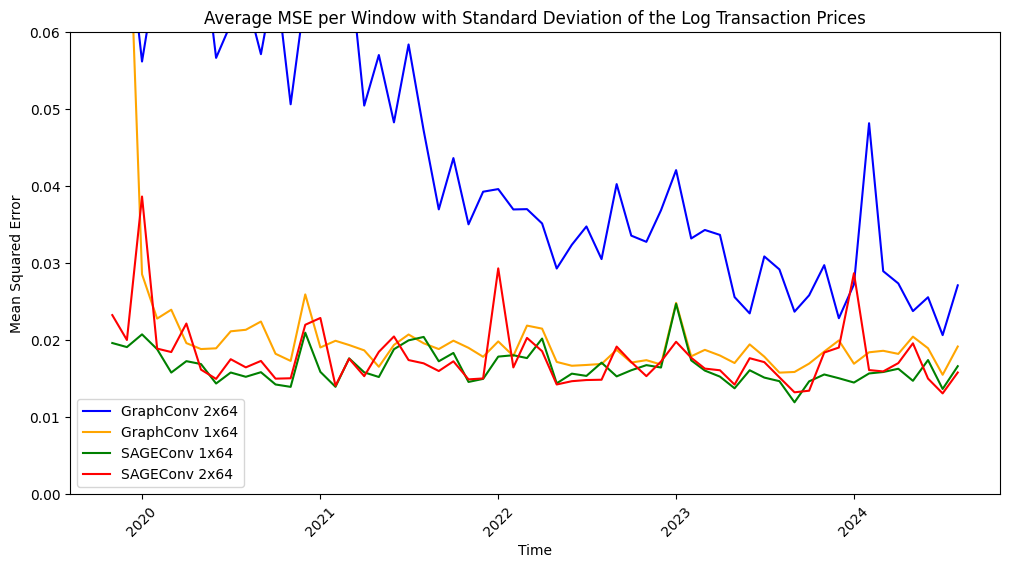

In [4]:
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_graphconv_1_b_64': np.mean((x['y_true'] - x['y_pred_graphconv_1_b_64']) ** 2),
        'upper_graphconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_graphconv_1_b_64']) ** 2, 0.95),
        'lower_graphconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_graphconv_1_b_64']) ** 2, 0.05),
        'mse_graphconv_2_b_64': np.mean((x['y_true'] - x['y_pred_graphconv_2_b_64']) ** 2),
        'upper_graphconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_graphconv_2_b_64']) ** 2, 0.95),
        'lower_graphconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_graphconv_2_b_64']) ** 2, 0.05),
        'mse_sageconv_1_b_64': np.mean((x['y_true'] - x['y_pred_sageconv_1_b_64']) ** 2),
        'upper_sageconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_sageconv_1_b_64']) ** 2, 0.95),
        'lower_sageconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_sageconv_1_b_64']) ** 2, 0.05),
        'mse_sageconv_2_b_64': np.mean((x['y_true'] - x['y_pred_sageconv_2_b_64']) ** 2),
        'upper_sageconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_sageconv_2_b_64']) ** 2, 0.95),
        'lower_sageconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_sageconv_2_b_64']) ** 2, 0.05),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_graphconv_2_b_64'], label='GraphConv 2x64', color='blue')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_graphconv_1_b_64'], label='GraphConv 1x64', color='orange')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_sageconv_1_b_64'], label='SAGEConv 1x64', color='green')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_sageconv_2_b_64'], label='SAGEConv 2x64', color='red')

plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.ylim(0, 0.06)
plt.xticks(rotation=45)
plt.legend()
plt.show()


C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_15748\820495785.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


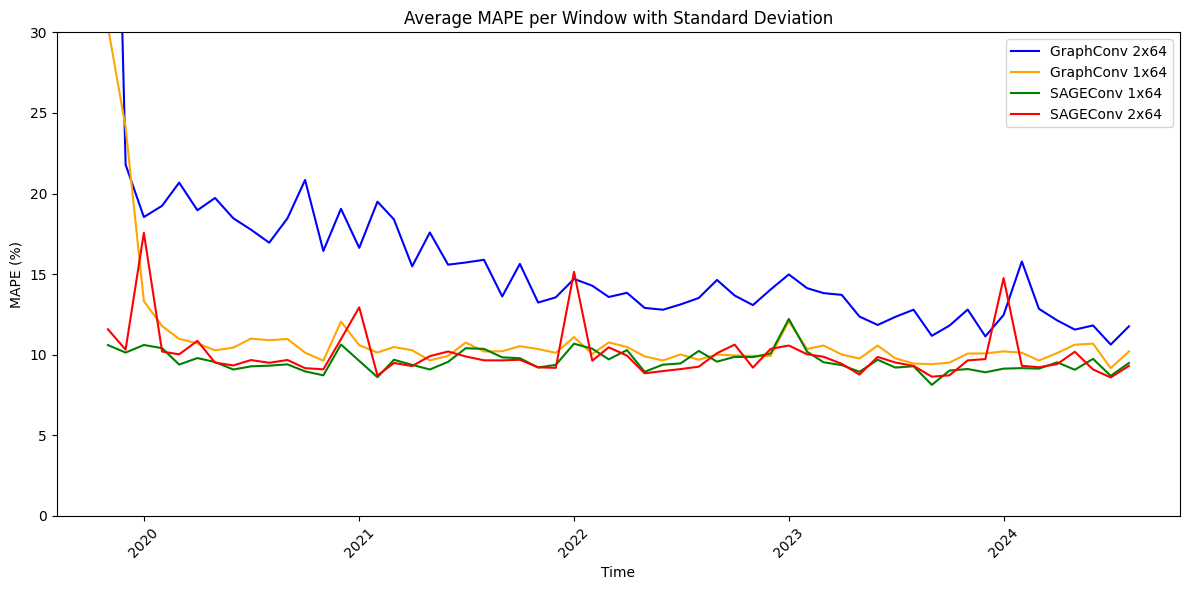

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_quantiles(y_true, y_pred, q):
    return np.quantile(np.abs((y_true - y_pred) / y_true) * 100, q)

def mape_std(y_true, y_pred):
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_sageconv_2_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_2_b_64'])),
        'std_sageconv_2_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_2_b_64'])),
        'lower_sageconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_2_b_64']), 0.05),
        'upper_sageconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_2_b_64']), 0.95),

        'mape_sageconv_1_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_1_b_64'])),
        'std_sageconv_1_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_1_b_64'])),
        'lower_sageconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_1_b_64']), 0.05),
        'upper_sageconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_sageconv_1_b_64']), 0.95),
        'mape_graphconv_1_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_1_b_64'])),
        'std_graphconv_1_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_1_b_64'])),
        'lower_graphconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_1_b_64']), 0.05),
        'upper_graphconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_1_b_64']), 0.95),
        'mape_graphconv_2_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_2_b_64'])),
        'std_graphconv_2_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_2_b_64'])),
        'lower_graphconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_2_b_64']), 0.05),
        'upper_graphconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_graphconv_2_b_64']), 0.95),
        
            
    })
).reset_index()

plt.figure(figsize=(12, 6))

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_graphconv_2_b_64'], label='GraphConv 2x64', color='blue')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_graphconv_1_b_64'], label='GraphConv 1x64', color='orange')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_sageconv_1_b_64'], label='SAGEConv 1x64', color='green')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_sageconv_2_b_64'], label='SAGEConv 2x64', color='red')

plt.xlabel('Time')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(0, 30)
plt.show()


In [ ]:
# compare_models(mse_std_per_window['mse_sageconv_1_b_64'], mse_std_per_window['mse_sageconv_1_b_128'], name_a='SAGEConv 1x64', name_b='SAGEConv 1x128')

KeyError: 'mse_sageconv_1_b_128'

##  Macro Encoder Comparisons

In [6]:
gatconv_gcnconv_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_gatconv_gcnconv_b_64.csv")
gcnconv_1_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_gcnconv_b_64.csv")
gcnconv_2_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_sageconv_b_64.csv")
gatconv_1_b_64 = pd.read_csv(f"../../outputs/all_test_predictions_gatconv_b_64.csv")

# Rename prediction columns for clarity
gatconv_gcnconv_b_64.rename(columns={'y_pred': 'y_pred_gatconv_gcnconv_b_64'}, inplace=True)
gcnconv_1_b_64.rename(columns={'y_pred': 'y_pred_gcnconv_1_b_64'}, inplace=True)
gcnconv_2_b_64.rename(columns={'y_pred': 'y_pred_gcnconv_2_b_64'}, inplace=True)
gatconv_1_b_64.rename(columns={'y_pred': 'y_pred_gatconv_1_b_64'}, inplace=True)

# Drop BUURTCODE if present
for df in [gatconv_gcnconv_b_64, gcnconv_1_b_64, gcnconv_2_b_64, gatconv_1_b_64]:
    if "BUURTCODE" in df.columns:
        df.drop(columns=["BUURTCODE"], inplace=True)

# Merge the dataframes on common columns
merged_df = gatconv_gcnconv_b_64.copy()
merged_df = pd.merge(merged_df, gcnconv_1_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, gcnconv_2_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, gatconv_1_b_64, on=['window_start', 'YEAR', 'MONTH', 'TRANSID', 'y_true'], how='outer')

merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)


      window_start  TRANSID     y_true  y_pred_gatconv_gcnconv_b_64  \
0          2014-10  5781036  12.103480                    12.081398   
1          2014-10  5781115  12.409014                    12.296254   
2          2014-10  5781187  13.369224                    13.241386   
3          2014-10  5781202  12.847926                    12.874154   
4          2014-10  5781203  11.982929                    12.141577   
...            ...      ...        ...                          ...   
54666      2019-07  8741507  12.748397                    12.635088   
54667      2019-07  8741513  12.415117                    12.416373   
54668      2019-07  8741549  13.190022                    13.049092   
54669      2019-07  8741579  12.971540                    12.935626   
54670      2019-07  8741589  13.437903                    13.372602   

       y_pred_gcnconv_1_b_64  y_pred_gcnconv_2_b_64  y_pred_gatconv_1_b_64  \
0                  12.058254              12.019947              12.0

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_15748\3039564151.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


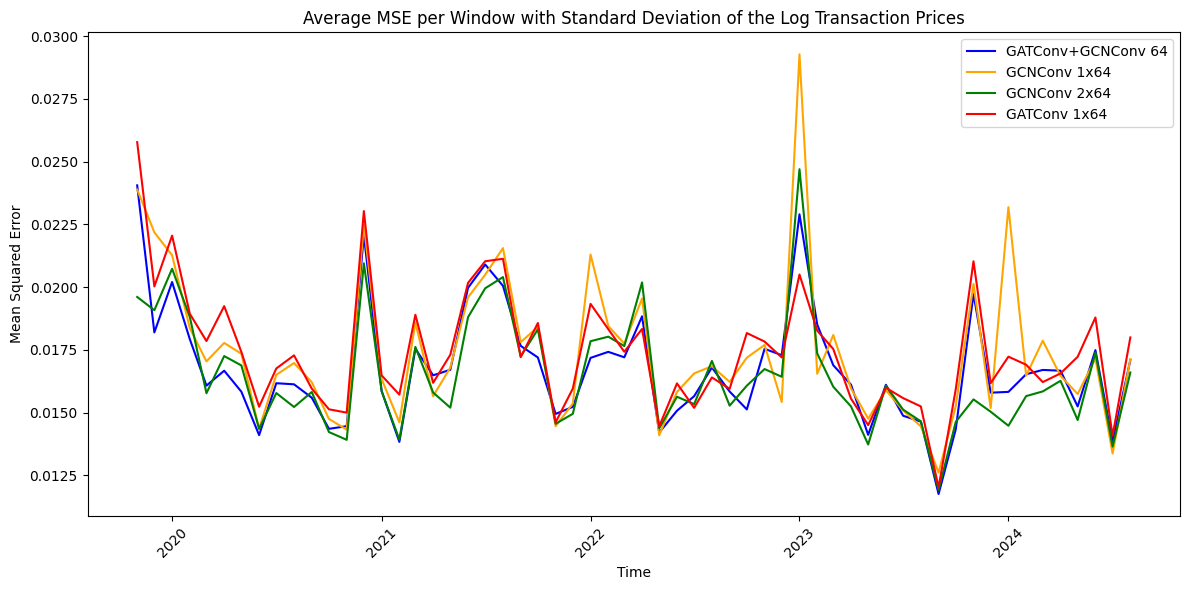

In [7]:
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_gatconv_gcnconv_b_64': np.mean((x['y_true'] - x['y_pred_gatconv_gcnconv_b_64']) ** 2),
        'upper_gatconv_gcnconv_b_64': np.quantile((x['y_true'] - x['y_pred_gatconv_gcnconv_b_64']) ** 2, 0.95),
        'lower_gatconv_gcnconv_b_64': np.quantile((x['y_true'] - x['y_pred_gatconv_gcnconv_b_64']) ** 2, 0.05),
        'mse_gcnconv_1_b_64': np.mean((x['y_true'] - x['y_pred_gcnconv_1_b_64']) ** 2),
        'upper_gcnconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_gcnconv_1_b_64']) ** 2, 0.95),
        'lower_gcnconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_gcnconv_1_b_64']) ** 2, 0.05),
        'mse_gcnconv_2_b_64': np.mean((x['y_true'] - x['y_pred_gcnconv_2_b_64']) ** 2),
        'upper_gcnconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_gcnconv_2_b_64']) ** 2, 0.95),
        'lower_gcnconv_2_b_64': np.quantile((x['y_true'] - x['y_pred_gcnconv_2_b_64']) ** 2, 0.05),
        'mse_gatconv_1_b_64': np.mean((x['y_true'] - x['y_pred_gatconv_1_b_64']) ** 2),
        'upper_gatconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_gatconv_1_b_64']) ** 2, 0.95),
        'lower_gatconv_1_b_64': np.quantile((x['y_true'] - x['y_pred_gatconv_1_b_64']) ** 2, 0.05),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_gatconv_gcnconv_b_64'], label='GATConv+GCNConv 64', color='blue')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_gcnconv_1_b_64'], label='GCNConv 1x64', color='orange')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_gcnconv_2_b_64'], label='GCNConv 2x64', color='green')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_gatconv_1_b_64'], label='GATConv 1x64', color='red')

plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_15748\1080724672.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


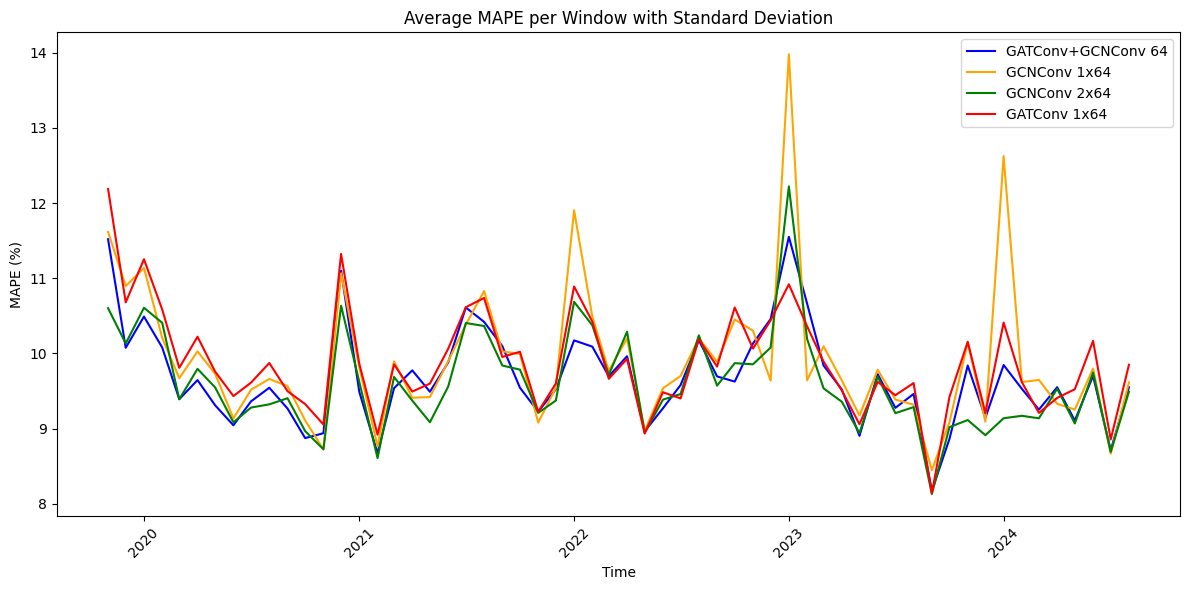

In [8]:

mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_gatconv_gcnconv_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_gcnconv_b_64'])),
        'std_gatconv_gcnconv_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_gcnconv_b_64'])),
        'lower_gatconv_gcnconv_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_gcnconv_b_64']), 0.05),
        'upper_gatconv_gcnconv_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_gcnconv_b_64']), 0.95),
        'mape_gcnconv_1_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_1_b_64'])),
        'std_gcnconv_1_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_1_b_64'])),
        'lower_gcnconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_1_b_64']), 0.05),
        'upper_gcnconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_1_b_64']), 0.95),
        'mape_gcnconv_2_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_2_b_64'])),
        'std_gcnconv_2_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_2_b_64'])),
        'lower_gcnconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_2_b_64']), 0.05),
        'upper_gcnconv_2_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gcnconv_2_b_64']), 0.95),
        'mape_gatconv_1_b_64': mape(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_1_b_64'])),
        'std_gatconv_1_b_64': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_1_b_64'])),
        'lower_gatconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_1_b_64']), 0.05),
        'upper_gatconv_1_b_64': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_gatconv_1_b_64']), 0.95),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_gatconv_gcnconv_b_64'], label='GATConv+GCNConv 64', color='blue')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_gcnconv_1_b_64'], label='GCNConv 1x64', color='orange')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_gcnconv_2_b_64'], label='GCNConv 2x64', color='green')

plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_gatconv_1_b_64'], label='GATConv 1x64', color='red')

plt.xlabel('Time')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
compare_models(mape_std_per_window['mape_gatconv_gcnconv_b_64'], mape_std_per_window['mape_gcnconv_2_b_64'], name_a='GATConv+GCNConv 64', name_b='GCNConv 2x64')

=== Model Comparison ===
Mean GATConv+GCNConv 64 Error: 9.6721
Mean GCNConv 2x64 Error: 9.6018
Mean Difference (A - B): 0.0703
Winner: GCNConv 2x64

Wilcoxon Test:     stat = 632.0, p = 0.0835561957802026
Diebold-Mariano:  stat = 1.7319, p = 0.0833


{'winner': 'GCNConv 2x64',
 'wilcoxon_stat': 632.0,
 'wilcoxon_p': 0.0835561957802026,
 'dm_stat': 1.7318783242051923,
 'dm_p': 0.08329522882794621}

## Online Learning Comparisons

In [12]:
baseline_df = pd.read_csv(f"../../outputs/all_test_predictions_dynamic_lr_00001_wd_0001_e_100_b_64_w_5_gl.csv")
final_df = pd.read_csv(f"../../outputs/all_test_predictions_sageconv_b_64.csv")
baseline_lgbm = pd.read_csv(f"../../outputs/all_test_predictions_ml.csv")
online_df = pd.read_csv(f"../../outputs/online_neighborhood_temporal_e_500_b_64_8_lr_00001.csv")
online_df_500_replay = pd.read_csv(f"../../outputs/online_neighborhood_temporal_e_500_100_b_64_8_lr_0001.csv")
online_df_200_replay = pd.read_csv(f"../../outputs/online_month_predictions_test.csv")
neighborhood_temporal_df = pd.read_csv(f"../../outputs/all_test_predictions_neighborhood_temporal1.csv")
neighborhood_temporal_df_patience = pd.read_csv(f"../../outputs/all_test_predictions_neighborhood_temporal_patience_10_batch_128_lr_0001.csv")

baseline_df.rename(columns={ 'y_pred': 'y_pred_baseline'}, inplace=True)
final_df.rename(columns={ 'y_pred': 'y_pred_final'}, inplace=True)
baseline_lgbm.rename(columns={ 'y_pred': 'y_pred_lgbm'}, inplace=True)
online_df.rename(columns={ 'y_pred': 'y_pred_online'}, inplace=True)
online_df_500_replay.rename(columns={ 'y_pred': 'y_pred_online_500_replay'}, inplace=True)
online_df_200_replay.rename(columns={ 'y_pred': 'y_pred_online_200_replay'}, inplace=True)
neighborhood_temporal_df.rename(columns={ 'y_pred': 'y_pred_neighborhood_temporal'}, inplace=True)
neighborhood_temporal_df_patience.rename(columns={ 'y_pred': 'y_pred_neighborhood_temporal_patience'}, inplace=True)

baseline_df.drop(columns=["BUURTCODE"], inplace=True)
final_df.drop(columns=["BUURTCODE"], inplace=True)
baseline_lgbm.drop(columns=["BUURTCODE","y_true"], inplace=True)
neighborhood_temporal_df.drop(columns=["BUURTCODE"], inplace=True)
neighborhood_temporal_df_patience.drop(columns=["BUURTCODE"], inplace=True)


# Merge the two dataframes on common columns
merged_df = pd.merge(baseline_df, final_df, on=['window_start', "YEAR", "MONTH",'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, baseline_lgbm, on=['window_start', "YEAR", "MONTH",'TRANSID'], how='inner')
merged_df = pd.merge(merged_df, neighborhood_temporal_df, on=['window_start', "YEAR", "MONTH",'TRANSID', 'y_true'], how='outer')
merged_df = pd.merge(merged_df, neighborhood_temporal_df_patience, on=['window_start', "YEAR", "MONTH",'TRANSID', 'y_true'], how='outer')
merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)

      window_start  TRANSID     y_true  y_pred_baseline  y_pred_final  \
0          2014-10  5781036  12.103480        11.973205     12.019947   
1          2014-10  5781115  12.409014        12.175118     12.313865   
2          2014-10  5781187  13.369224        13.002164     13.350024   
3          2014-10  5781202  12.847926        12.350430     12.857819   
4          2014-10  5781203  11.982929        12.154861     12.202458   
...            ...      ...        ...              ...           ...   
54666      2019-07  8741507  12.748397        12.776637     12.723959   
54667      2019-07  8741513  12.415117        12.344392     12.461791   
54668      2019-07  8741549  13.190022        13.074518     12.986893   
54669      2019-07  8741579  12.971540        12.933887     12.947814   
54670      2019-07  8741589  13.437903        13.383229     13.402357   

       y_pred_lgbm  y_pred_neighborhood_temporal  \
0        11.944604                     12.172407   
1        12.285646 

In [12]:
final_df

,window_start,YEAR,MONTH,TRANSID,y_true,y_pred_final
0,2014-10,2019,11,5793455,12.863593,12.905668
1,2014-10,2019,11,5785580,12.847926,12.920620
2,2014-10,2019,11,5796120,12.334906,12.390343
3,2014-10,2019,11,5782777,12.278394,12.559343
4,2014-10,2019,11,5796410,12.072541,12.047544
...,...,...,...,...,...,...
54666,2019-07,2024,8,8722107,12.948010,12.840471
54667,2019-07,2024,8,8739935,12.994530,12.873444
54668,2019-07,2024,8,8724698,12.786891,12.656372
54669,2019-07,2024,8,8722063,13.102160,13.108351


In [13]:
final_df.drop(columns=["window_start"], inplace=True)
online_df.drop(columns=["window_start", "y_true"], inplace=True)
online_df_500_replay.drop(columns=["window_start", "y_true"], inplace=True)
online_df_200_replay.drop(columns=["window_start", "y_true"], inplace=True)

In [14]:

merged_df = pd.merge(final_df, online_df,  on=[ "YEAR", "MONTH",'TRANSID'], how='inner')
merged_df = pd.merge(merged_df, online_df_500_replay, on=[ "YEAR", "MONTH",'TRANSID'], how='inner')
merged_df = pd.merge(merged_df, online_df_200_replay, on=[ "YEAR", "MONTH",'TRANSID'], how='inner')
merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)

       TRANSID     y_true  y_pred_final  BUURTCODE_x  y_pred_online  \
0      5793455  12.863593     12.905668          209      14.346371   
1      5785580  12.847926     12.920620          386      13.172681   
2      5796120  12.334906     12.390343          207      11.795385   
3      5782777  12.278394     12.559343          281      12.486041   
4      5796410  12.072541     12.047544           73      11.486943   
...        ...        ...           ...          ...            ...   
54666  8722107  12.948010     12.840471          238      12.960715   
54667  8739935  12.994530     12.873444          189      12.714177   
54668  8724698  12.786891     12.656372          207      12.468127   
54669  8722063  13.102160     13.108351          169      13.178014   
54670  8734801  12.666657     12.521019          252      12.529853   

       BUURTCODE_y  y_pred_online_500_replay  BUURTCODE  \
0              209                 13.063157        209   
1              386           

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_26580\4035670560.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


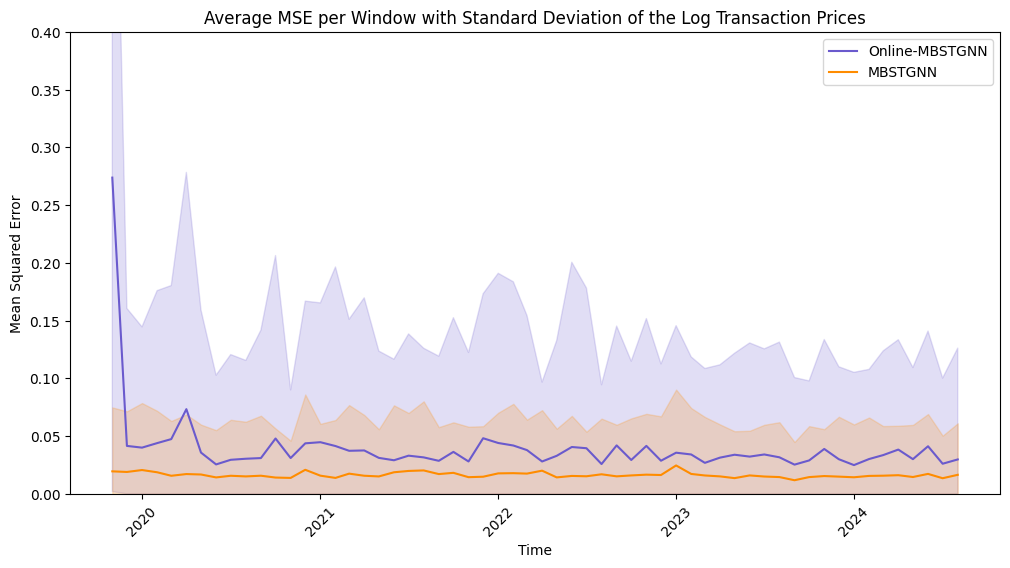

In [16]:
# Calculate MSE and standard deviation per month for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_online': np.mean((x['y_true'] - x['y_pred_online']) ** 2),
        'upper_online': np.quantile((x['y_true'] - x['y_pred_online']) ** 2, 0.95),
        'lower_online': np.quantile((x['y_true'] - x['y_pred_online']) ** 2, 0.05),
        'mse_final': np.mean((x['y_true'] - x['y_pred_final']) ** 2),
        'upper_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.95),
        'lower_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.05),
        'mse_online_500': np.mean((x['y_true'] - x['y_pred_online_500_replay']) ** 2),
        'upper_online_500': np.quantile((x['y_true'] - x['y_pred_online_500_replay']) ** 2, 0.95),
        'lower_online_500': np.quantile((x['y_true'] - x['y_pred_online_500_replay']) ** 2, 0.05),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_online'], label='Online-MBSTGNN', color='slateblue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_online'],
    mse_std_per_window['upper_online'],
    color='slateblue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='MBSTGNN',color='darkorange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='darkorange', alpha=0.2
)
# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_online_500'], label='Online', color='green')
# plt.fill_between(
#     mse_std_per_window['DATE'],
#     mse_std_per_window['lower_online_500'],
#     mse_std_per_window['upper_online_500'],
#     color='green', alpha=0.2
# )
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend()



C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_26580\14048458.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


         DATE  mape_online  std_online  lower_online  upper_online  \
0  2019-11-01    53.546755  442.147270      4.469773     64.228160   
1  2019-12-01    16.075076   17.167148      0.987570     40.680474   
2  2020-01-01    15.366853   23.066418      0.956218     39.971279   
3  2020-02-01    15.817454   23.073955      1.094620     42.511889   
4  2020-03-01    16.321077   16.722901      1.028673     37.529396   
5  2020-04-01    20.049420   16.429127      1.224992     44.582487   
6  2020-05-01    14.362282   14.882863      1.096409     39.336656   
7  2020-06-01    12.319979   11.882651      0.961567     32.926503   
8  2020-07-01    12.476007   10.439808      0.912246     31.817290   
9  2020-08-01    13.325330   11.539126      1.065739     32.937656   
10 2020-09-01    13.528404   12.648449      0.830732     37.530428   
11 2020-10-01    15.666600   24.070163      1.146134     41.617691   
12 2020-11-01    13.320933   34.380901      0.916955     32.707216   
13 2020-12-01    17.

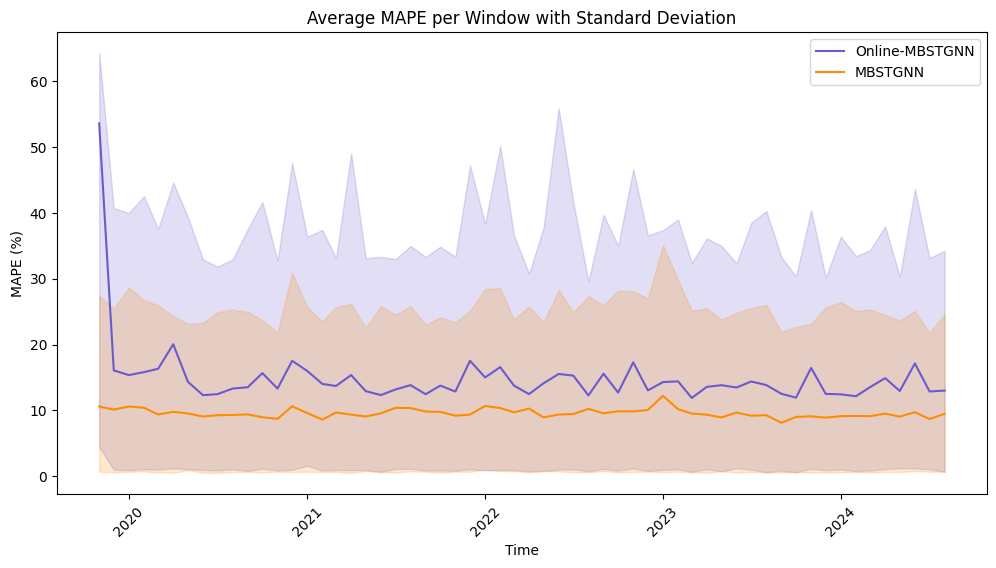

In [17]:
# Calculate MAPE and its standard deviation per window for baseline and final predictions (after exponentiating)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_quantiles(y_true, y_pred, q):
    return np.quantile(np.abs((y_true - y_pred) / y_true) * 100, q)

    # Now, update the groupby lambda to use the quantiles correctly:
def mape_std(y_true, y_pred):
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_online': mape(np.exp(x['y_true']), np.exp(x['y_pred_online'])),
        'std_online': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_online'])),
        'lower_online': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_online']), 0.05),
        'upper_online': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_online']), 0.95),
        'mape_final': mape(np.exp(x['y_true']), np.exp(x['y_pred_final'])),
        'std_final': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_final'])),
        'lower_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_final']), 0.05),
        'upper_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_final']), 0.95),
    })
).reset_index()
print(mape_std_per_window)
plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_online'], label='Online-MBSTGNN',color='slateblue')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_online'],
    mape_std_per_window['upper_online'],
    color='slateblue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='MBSTGNN',color='darkorange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='darkorange', alpha=0.2
)

plt.xlabel('Time')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()



In [1]:
# Calculate MSE and standard deviation per window for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_baseline': np.mean((x['y_true'] - x['y_pred_online']) ** 2),
        'upper_baseline': np.quantile((x['y_true'] - x['y_pred_online']) ** 2, 0.95),
        'lower_baseline': np.quantile((x['y_true'] - x['y_pred_online']) ** 2, 0.05),
        'mse_final': np.mean((x['y_true'] - x['y_pred_final']) ** 2),
        'upper_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.95),
        'lower_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.05),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Macro Graph+MLP Baseline MSE', color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='Proposed Model MSE',color='orange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='orange', alpha=0.2
)

plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

NameError: name 'merged_df' is not defined

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_28348\794989234.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


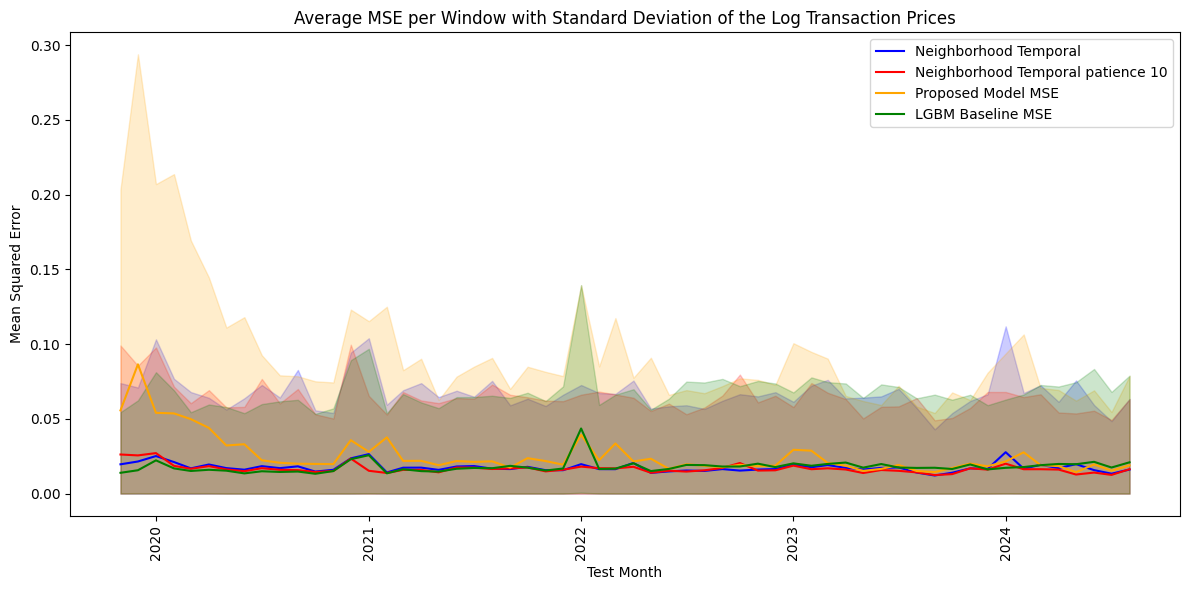

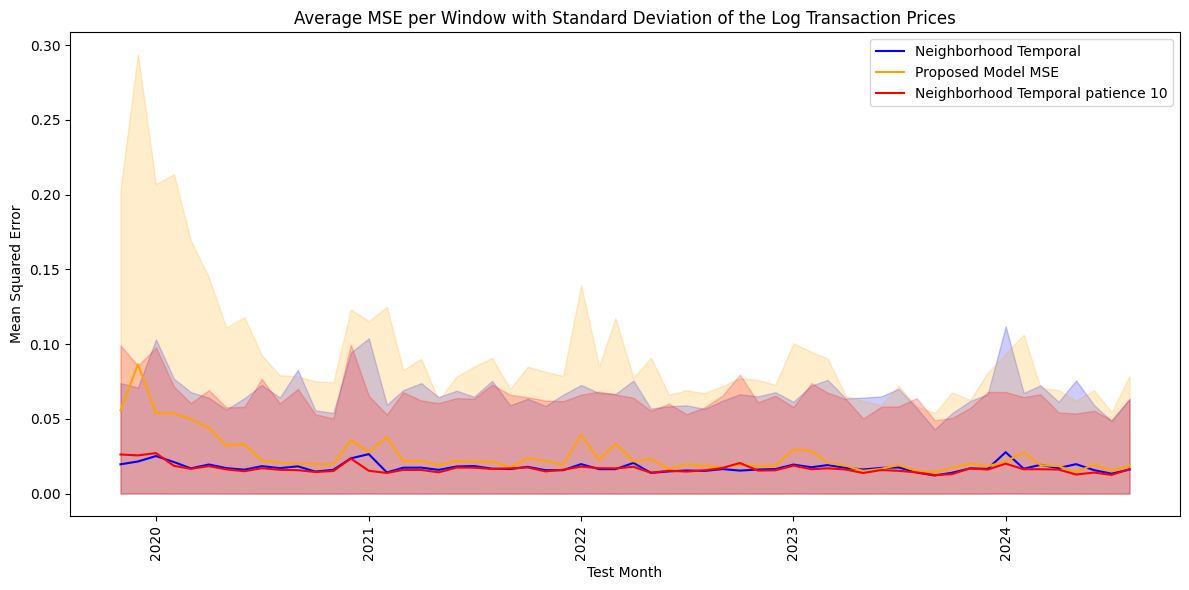

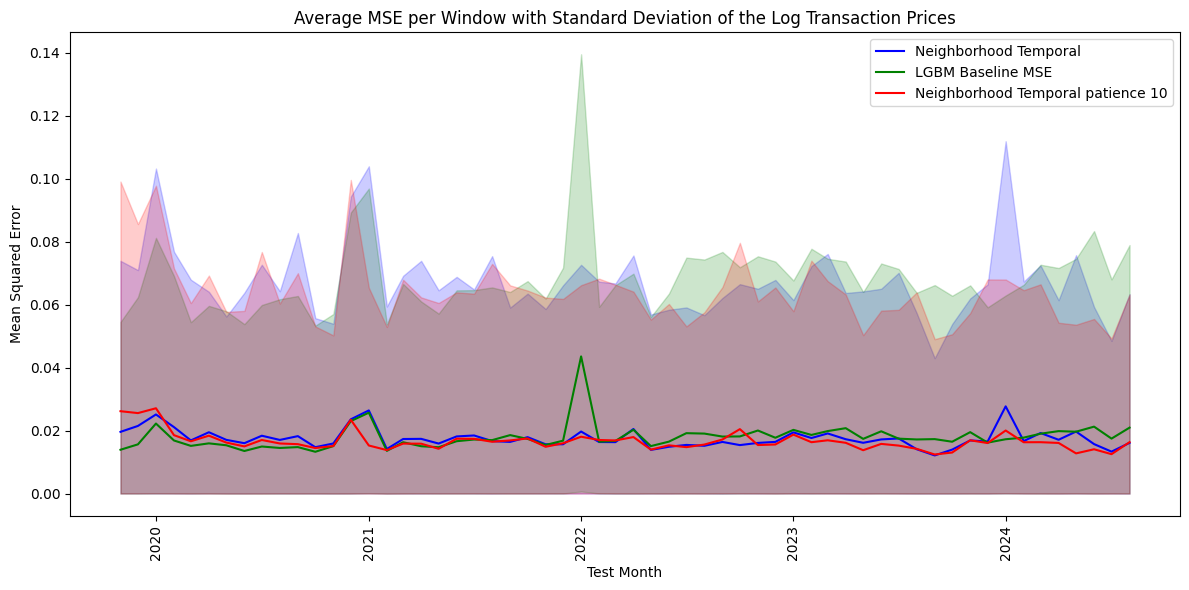

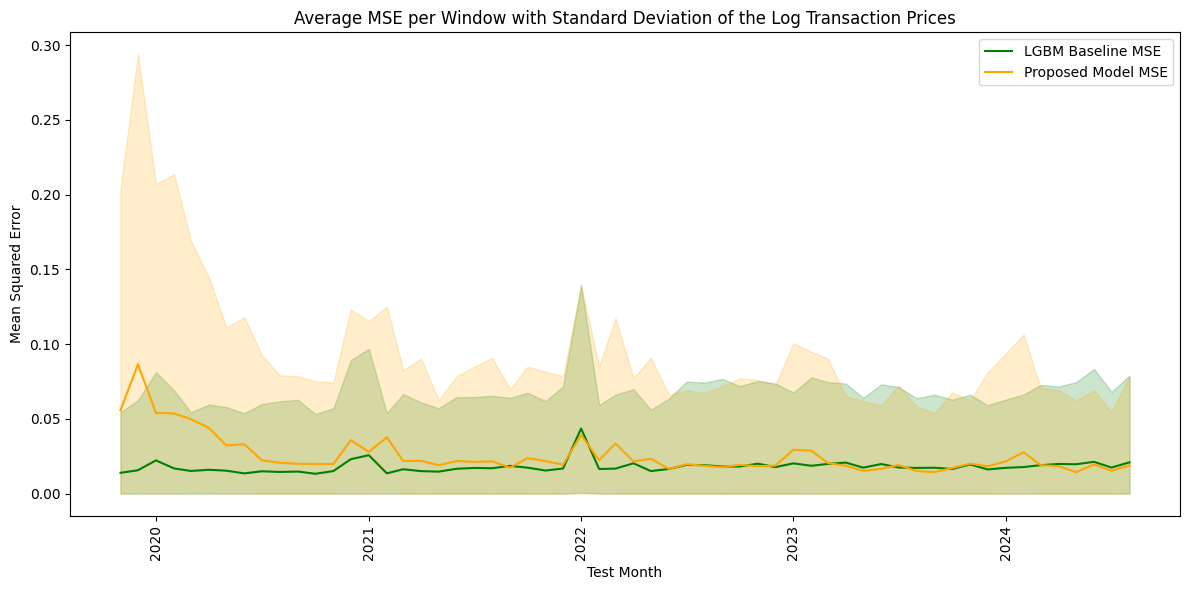

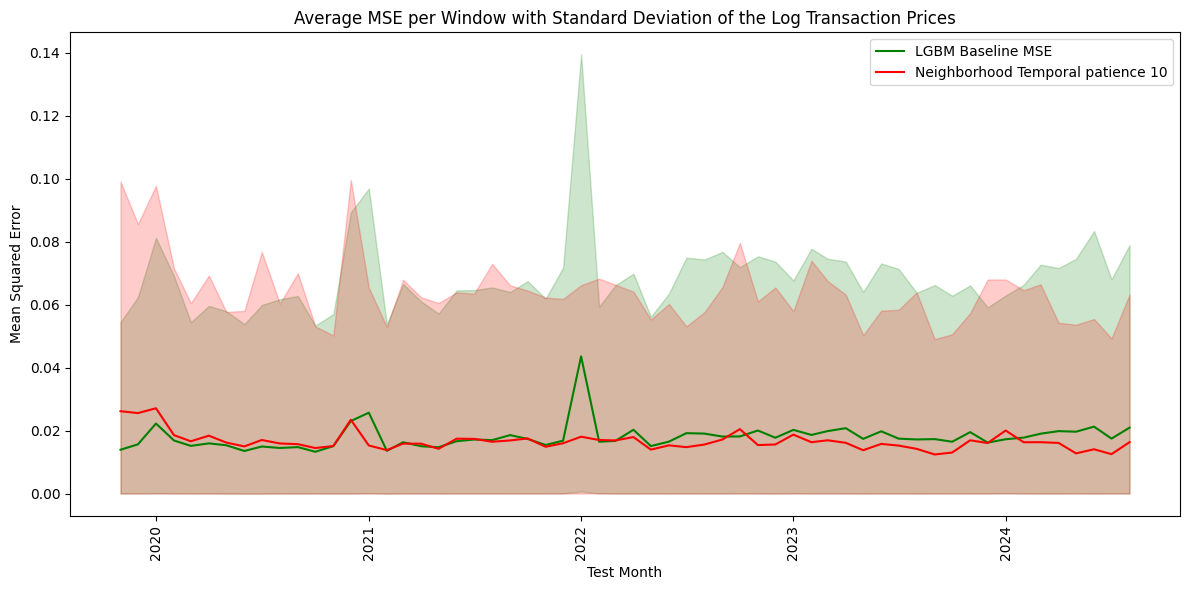

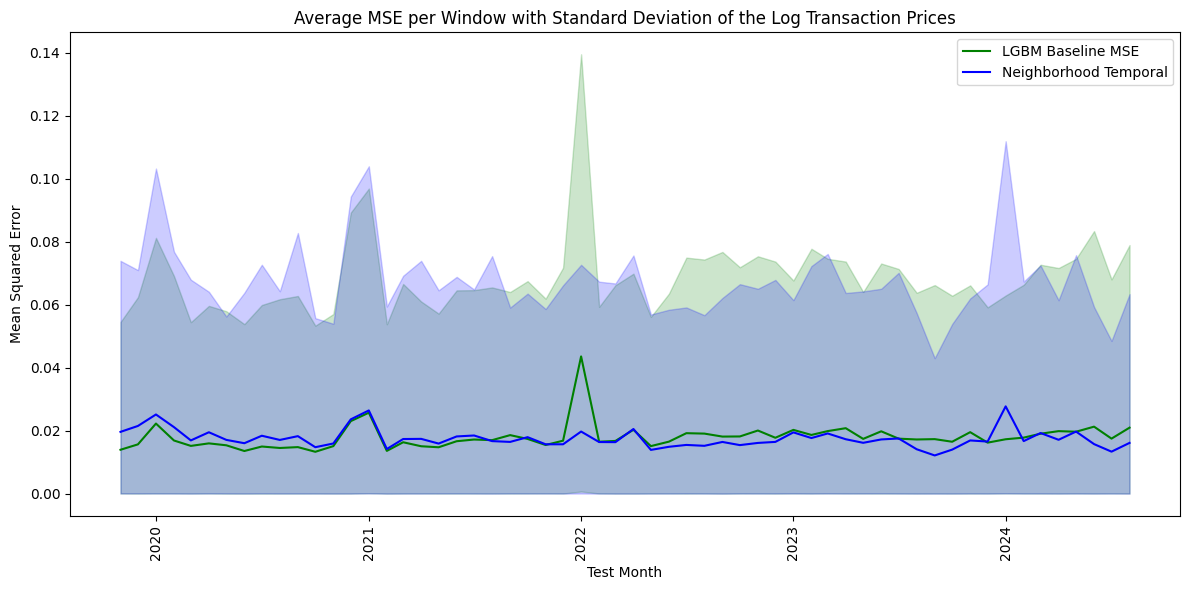

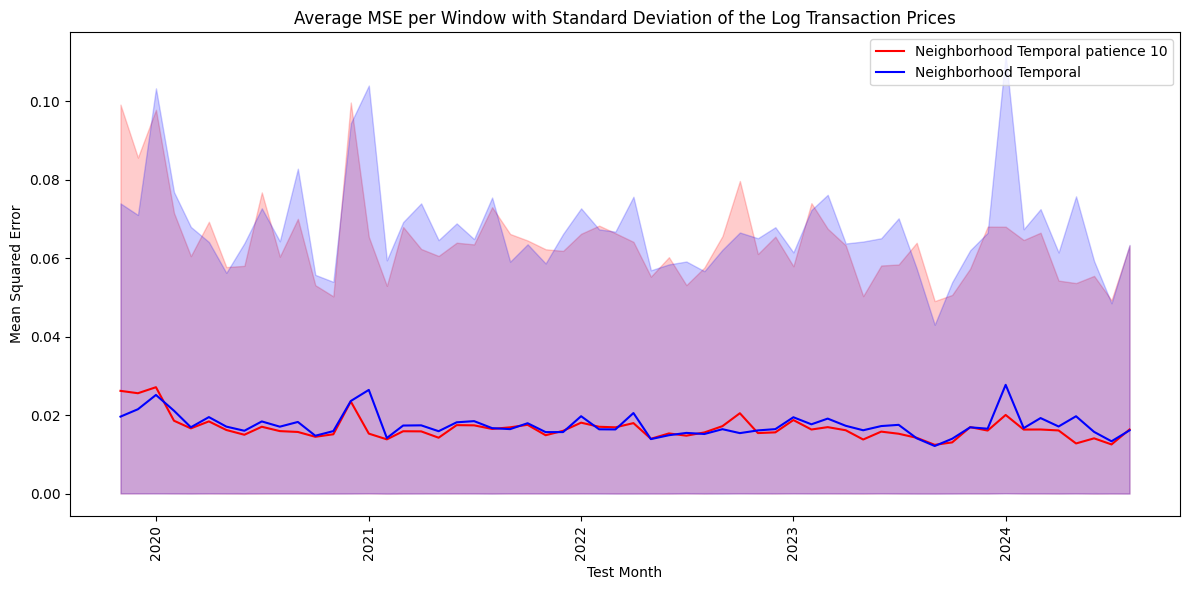

In [28]:
# Calculate MSE and standard deviation per window for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_baseline': np.mean((x['y_true'] - x['y_pred_neighborhood_temporal']) ** 2),
        'upper_baseline': np.quantile((x['y_true'] - x['y_pred_neighborhood_temporal']) ** 2, 0.95),
        'lower_baseline': np.quantile((x['y_true'] - x['y_pred_neighborhood_temporal']) ** 2, 0.05),
        'mse_final': np.mean((x['y_true'] - x['y_pred_final']) ** 2),
        'upper_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.95),
        'lower_final': np.quantile((x['y_true'] - x['y_pred_final']) ** 2, 0.05),
        'mse_lgbm': np.mean((x['y_true'] - x['y_pred_lgbm']) ** 2),
        'upper_lgbm': np.quantile((x['y_true'] - x['y_pred_lgbm']) ** 2, 0.95),
        'lower_lgbm': np.quantile((x['y_true'] - x['y_pred_lgbm']) ** 2, 0.05),
        'mse_neigh': np.mean((x['y_true'] - x['y_pred_neighborhood_temporal_patience']) ** 2),
        'upper_neigh': np.quantile((x['y_true'] - x['y_pred_neighborhood_temporal_patience']) ** 2, 0.95),
        'lower_neigh': np.quantile((x['y_true'] - x['y_pred_neighborhood_temporal_patience']) ** 2, 0.05),
    })
).reset_index()

# Plot the MSE per window with standard deviation as shaded area
plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Neighborhood Temporal', color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_neigh'], label='Neighborhood Temporal patience 10', color='red')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_neigh'],
    mse_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='Proposed Model MSE',color='orange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LGBM Baseline MSE', color='green')
plt.fill_between(
    mse_std_per_window['DATE'], 
    mse_std_per_window['lower_lgbm'],
    mse_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Neighborhood Temporal', color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='Proposed Model MSE',color='orange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_neigh'], label='Neighborhood Temporal patience 10', color='red')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_neigh'],
    mse_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)

plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LGBM Baseline MSE', color='green')
plt.fill_between(
    mse_std_per_window['DATE'], 
    mse_std_per_window['lower_lgbm'],
    mse_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_neigh'], label='Neighborhood Temporal patience 10', color='red')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_neigh'],
    mse_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LGBM Baseline MSE', color='green')
plt.fill_between(
    mse_std_per_window['DATE'], 
    mse_std_per_window['lower_lgbm'],
    mse_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='Proposed Model MSE',color='orange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='orange', alpha=0.2
)

plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LGBM Baseline MSE', color='green')
plt.fill_between(
    mse_std_per_window['DATE'], 
    mse_std_per_window['lower_lgbm'],
    mse_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_neigh'], label='Neighborhood Temporal patience 10', color='red')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_neigh'],
    mse_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LGBM Baseline MSE', color='green')
plt.fill_between(
    mse_std_per_window['DATE'], 
    mse_std_per_window['lower_lgbm'],
    mse_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_neigh'], label='Neighborhood Temporal patience 10', color='red')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_neigh'],
    mse_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('Average MSE per Window with Standard Deviation of the Log Transaction Prices')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

         DATE  mape_baseline  std_baseline  lower_baseline  upper_baseline  \
0  2019-11-01      10.661751     10.705775        0.883992       28.280467   
1  2019-12-01      10.714220     14.502591        0.837707       27.075207   
2  2020-01-01      11.710923     14.837956        0.767589       33.536645   
3  2020-02-01      11.576915     11.706402        0.725981       31.523078   
4  2020-03-01       9.604949      9.533290        0.597707       26.151612   
5  2020-04-01      10.000615      9.277941        0.859107       24.553105   
6  2020-05-01       9.601440     10.087769        0.770739       23.349289   
7  2020-06-01       9.814078      9.574685        0.652434       26.498319   
8  2020-07-01      10.616569     10.156416        0.870650       29.248148   
9  2020-08-01       9.789202      9.143255        0.699323       25.817856   
10 2020-09-01       9.905772      8.408824        0.731214       26.271886   
11 2020-10-01       9.044777      8.633023        0.664239      

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_28348\3909750953.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


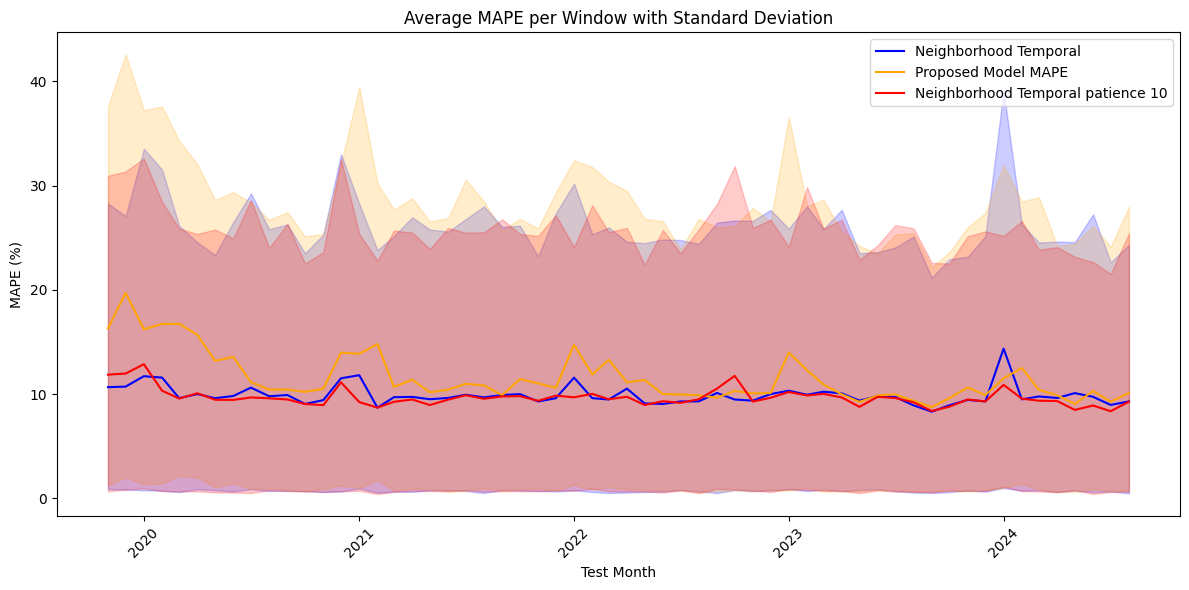

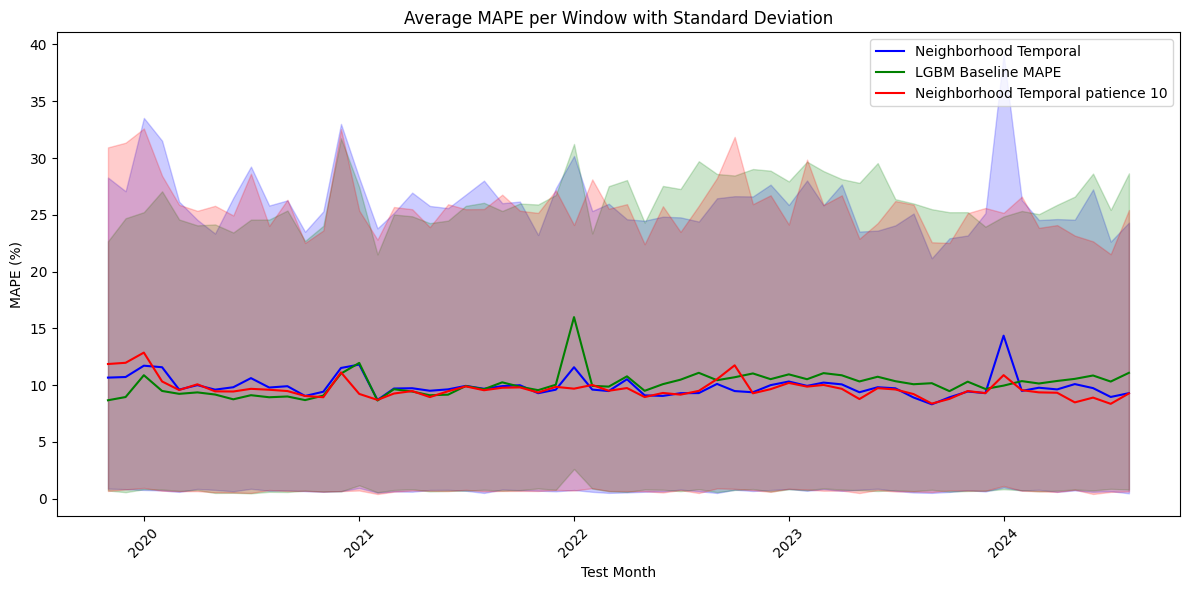

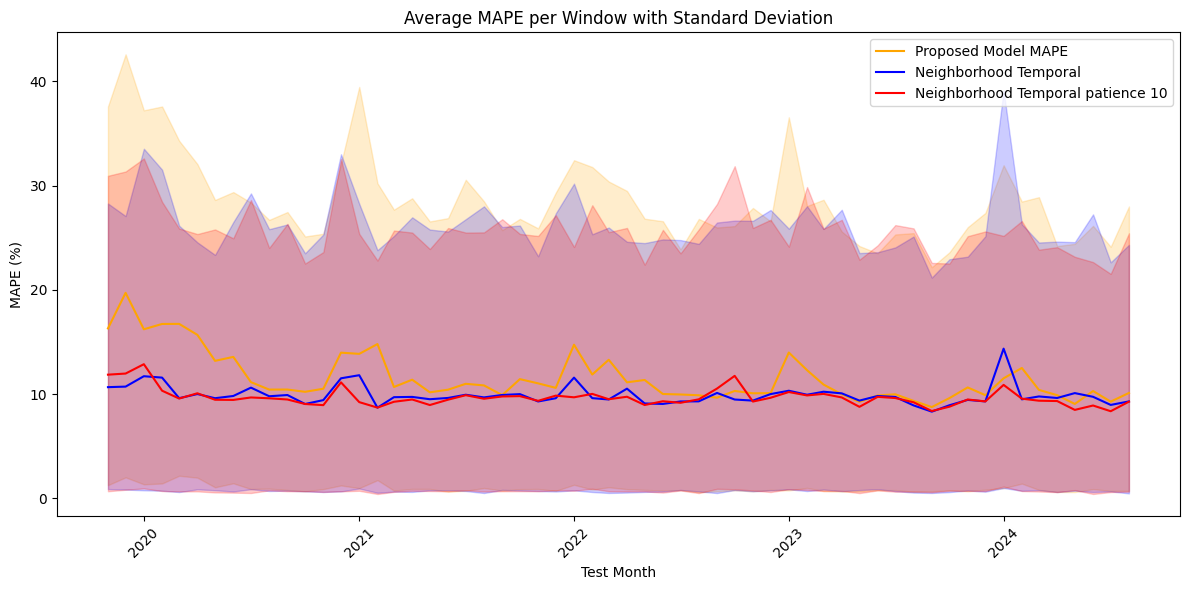

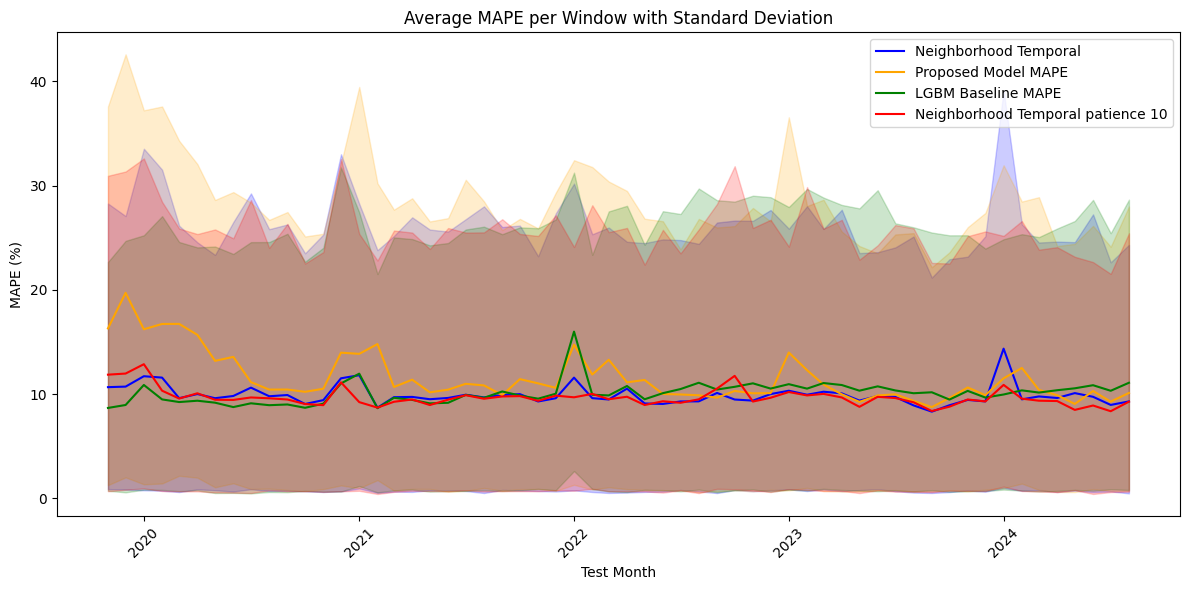

In [29]:
# Calculate MAPE and its standard deviation per window for baseline and final predictions (after exponentiating)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # The issue is that the 'lower_baseline', 'upper_baseline', 'lower_final', and 'upper_final' columns are not correct.
    # In your lambda, you are calling np.quantile on a single MAPE value (the mean), not on the array of absolute percentage errors.
    # You need to compute the quantiles on the array of absolute percentage errors, not on the mean.

def mape_quantiles(y_true, y_pred, q):
    return np.quantile(np.abs((y_true - y_pred) / y_true) * 100, q)

    # Now, update the groupby lambda to use the quantiles correctly:
def mape_std(y_true, y_pred):
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_baseline': mape(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal'])),
        'std_baseline': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal'])),
        'lower_baseline': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal']), 0.05),
        'upper_baseline': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal']), 0.95),
        'mape_final': mape(np.exp(x['y_true']), np.exp(x['y_pred_final'])),
        'std_final': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_final'])),
        'lower_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_final']), 0.05),
        'upper_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_final']), 0.95),
        'mape_lgbm': mape(np.exp(x['y_true']), np.exp(x['y_pred_lgbm'])),
        'std_lgbm': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_lgbm'])),
        'lower_lgbm': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_lgbm']), 0.05),
        'upper_lgbm': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_lgbm']), 0.95),
        'mape_neigh': mape(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal_patience'])),
        'std_neigh': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal_patience'])),
        'lower_neigh': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal_patience']), 0.05),
        'upper_neigh': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_neighborhood_temporal_patience']), 0.95),
    })
).reset_index()
print(mape_std_per_window)
plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_baseline'],
    mape_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='Proposed Model MAPE',color='orange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_neigh'], label='Neighborhood Temporal patience 10',color='red')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_neigh'],
    mape_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_baseline'],
    mape_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_lgbm'], label='LGBM Baseline MAPE',color='green')
plt.fill_between(
    mape_std_per_window['DATE'], 
    mape_std_per_window['lower_lgbm'],  
    mape_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_neigh'], label='Neighborhood Temporal patience 10',color='red')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_neigh'],
    mape_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='Proposed Model MAPE',color='orange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mape_std_per_window['DATE'], 
    mape_std_per_window['lower_baseline'],  
    mape_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_neigh'], label='Neighborhood Temporal patience 10',color='red')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_neigh'],
    mape_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_baseline'], label='Neighborhood Temporal',color='blue')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_baseline'],
    mape_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='Proposed Model MAPE',color='orange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_lgbm'], label='LGBM Baseline MAPE', color='green')
plt.fill_between(
    mape_std_per_window['DATE'], 
    mape_std_per_window['lower_lgbm'],  
    mape_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_neigh'], label='Neighborhood Temporal patience 10',color='red')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_neigh'],
    mape_std_per_window['upper_neigh'],
    color='red', alpha=0.2
)
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('Average MAPE per Window with Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
compare_models(mape_std_per_window['mape_lgbm'], mape_std_per_window['mape_neigh'], name_a='LGBM', name_b='Proposed Model')

=== Model Comparison ===
Mean LGBM Error: 10.1038
Mean Proposed Model Error: 9.6705
Mean Difference (A - B): 0.4333
Winner: Proposed Model

Wilcoxon Test:     stat = 490.0, p = 0.004657300656924901
Diebold-Mariano:  stat = 2.2474, p = 0.0246


{'winner': 'Proposed Model',
 'wilcoxon_stat': 490.0,
 'wilcoxon_p': 0.004657300656924901,
 'dm_stat': 2.2474448308824617,
 'dm_p': 0.024611612639488627}

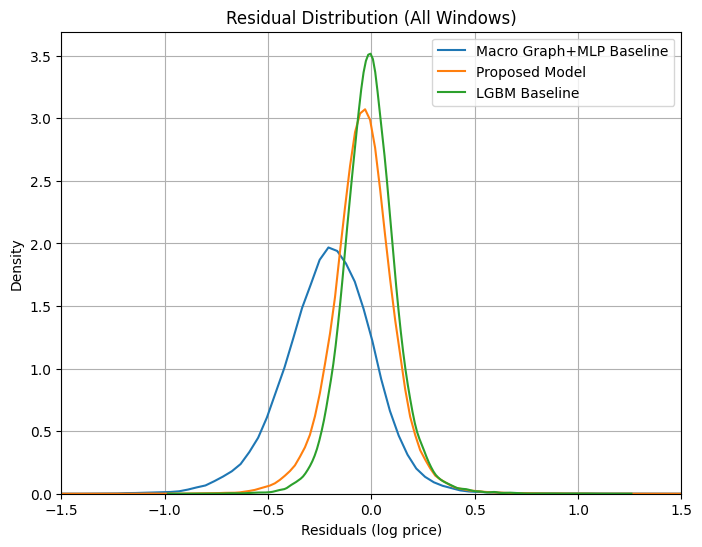

In [40]:
import seaborn as sns
merged_df['residual_baseline'] = merged_df['y_pred_baseline']-merged_df['y_true'] 
merged_df['residual_final'] = merged_df['y_pred_final']- merged_df['y_true'] 
merged_df['residual_lgbm'] =  merged_df['y_pred_lgbm'] - merged_df['y_true']

plt.figure(figsize=(8, 6))
sns.kdeplot(merged_df['residual_baseline'], label='Macro Graph+MLP Baseline')
sns.kdeplot(merged_df['residual_final'], label='Proposed Model')
sns.kdeplot(merged_df['residual_lgbm'], label='LGBM Baseline')
plt.title('Residual Distribution (All Windows)')
plt.xlabel('Residuals (log price)')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.grid(True)


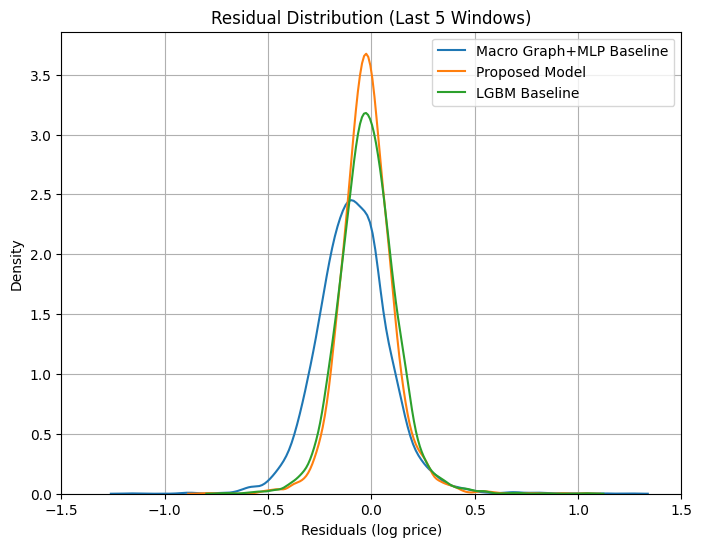

In [41]:
N = 5



last_N_dates = merged_df['DATE'].sort_values().unique()[-N:]
residuals_last_N = merged_df[merged_df['DATE'].isin(last_N_dates)]

plt.figure(figsize=(8, 6))
sns.kdeplot(residuals_last_N['y_pred_baseline'] - residuals_last_N['y_true'], label='Macro Graph+MLP Baseline')
sns.kdeplot(residuals_last_N['y_pred_final'] - residuals_last_N['y_true'], label='Proposed Model')
sns.kdeplot(residuals_last_N['y_pred_lgbm'] - residuals_last_N['y_true'], label='LGBM Baseline')
plt.title(f'Residual Distribution (Last {N} Windows)')
plt.xlabel('Residuals (log price)')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

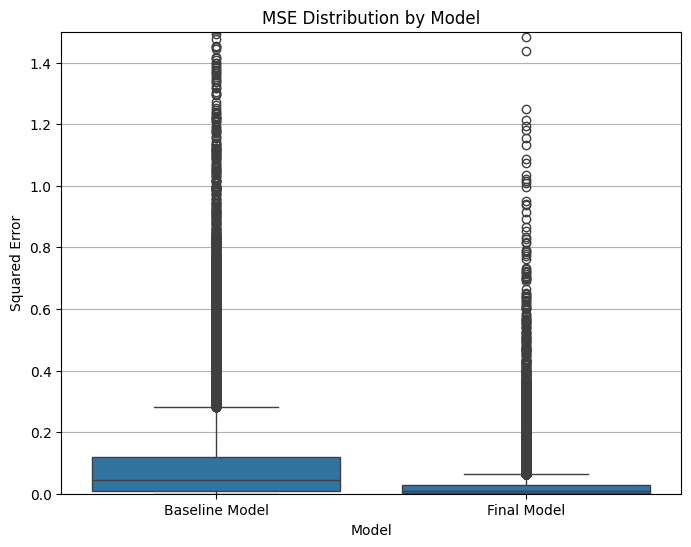

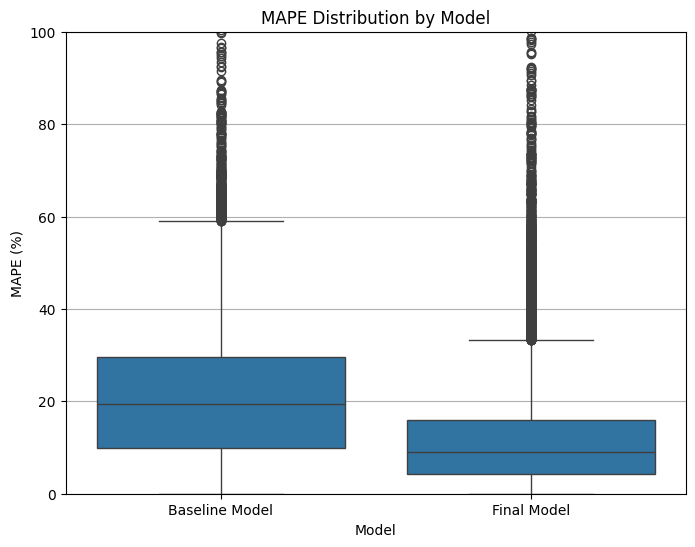

In [42]:

df = merged_df.copy()

# Compute squared error and absolute percentage error for each row
df["SE_baseline"] = (df["y_true"] - df["y_pred_baseline"])**2
df["SE_final"] = (df["y_true"] - df["y_pred_final"])**2

df["APE_baseline"] = np.abs((np.exp(df["y_true"]) - np.exp(df["y_pred_baseline"])) / np.exp(df["y_true"])) * 100
df["APE_final"] = np.abs((np.exp(df["y_true"]) - np.exp(df["y_pred_final"])) / np.exp(df["y_true"])) * 100

# Prepare data for boxplot
mse_long = df[["SE_baseline", "SE_final"]].melt(var_name="Model", value_name="Squared Error")
mse_long["Model"] = mse_long["Model"].map({
    "SE_baseline": "Baseline Model",
    "SE_final": "Final Model"
})

mape_long = df[["APE_baseline", "APE_final"]].melt(var_name="Model", value_name="MAPE")
mape_long["Model"] = mape_long["Model"].map({
    "APE_baseline": "Baseline Model",
    "APE_final": "Final Model"
})

plt.figure(figsize=(8, 6))
sns.boxplot(data=mse_long, x="Model", y="Squared Error")
plt.title("MSE Distribution by Model")
plt.ylabel("Squared Error")
plt.xlabel("Model")
plt.ylim(-0, 1.5)
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=mape_long, x="Model", y="MAPE")
plt.title("MAPE Distribution by Model")
plt.ylabel("MAPE (%)")
plt.xlabel("Model")
plt.ylim(0,100)
plt.grid(True, axis='y')
plt.show()


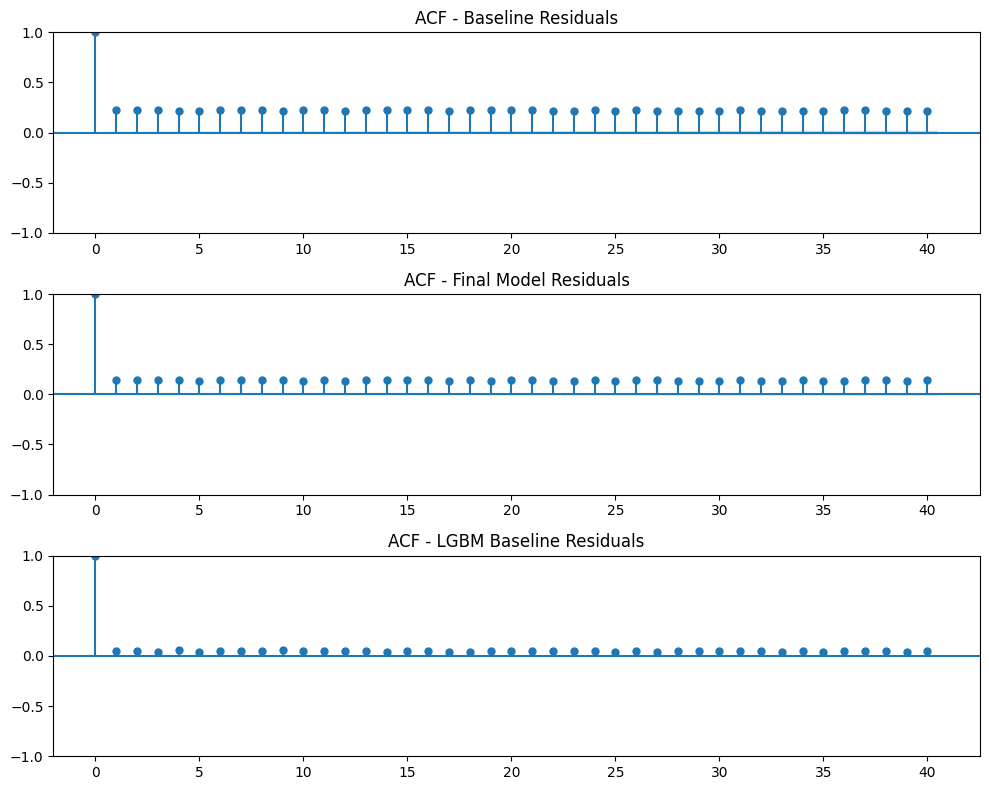

In [43]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df
# Compute residuals for each model
df["residual_baseline"] = df["y_true"] - df["y_pred_baseline"]
df["residual_final"] = df["y_true"] - df["y_pred_final"]
df["residual_lgbm"] = df["y_true"] - df["y_pred_lgbm"]

# Group by time (e.g., monthly) and compute average residuals if needed
# Or keep them at transaction-level if already sorted by time

# ACF plots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

sm.graphics.tsa.plot_acf(df["residual_baseline"], ax=axes[0], lags=40)
axes[0].set_title("ACF - Baseline Residuals")

sm.graphics.tsa.plot_acf(df["residual_final"], ax=axes[1], lags=40)
axes[1].set_title("ACF - Final Model Residuals")

sm.graphics.tsa.plot_acf(df["residual_lgbm"], ax=axes[2], lags=40)
axes[2].set_title("ACF - LGBM Baseline Residuals")

plt.tight_layout()
plt.show()


In [44]:
mse_all_baseline = np.mean((df['y_true'] - df['y_pred_baseline']) ** 2)
mse_std_all_baseline = np.std((df['y_true'] - df['y_pred_baseline']) ** 2)
mape_all_baseline = np.mean(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_baseline'])) / np.exp(df['y_true'])) * 100)
mape_std_all_baseline = np.std(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_baseline'])) / np.exp(df['y_true'])) * 100)

mse_all_final = np.mean((df['y_true'] - df['y_pred_final']) ** 2)
mse_std_all_final = np.std((df['y_true'] - df['y_pred_final']) ** 2)
mape_all_final = np.mean(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_final'])) / np.exp(df['y_true'])) * 100)
mape_std_all_final = np.std(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_final'])) / np.exp(df['y_true'])) * 100)

mse_all_lgbm = np.mean((df['y_true'] - df['y_pred_lgbm']) ** 2)
mse_std_all_lgbm = np.std((df['y_true'] - df['y_pred_lgbm']) ** 2)
mape_all_lgbm = np.mean(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_lgbm'])) / np.exp(df['y_true'])) * 100)
mape_std_all_lgbm = np.std(np.abs((np.exp(df['y_true']) - np.exp(df['y_pred_lgbm'])) / np.exp(df['y_true'])) * 100)

In [45]:
print(f"Baseline Model - MSE: {mse_all_baseline:.4f}, MSE Std: {mse_std_all_baseline:.4f}, MAPE: {mape_all_baseline:.2f}%, MAPE Std: {mape_std_all_baseline:.2f}%")
print(f"Final Model - MSE: {mse_all_final:.4f}, MSE Std: {mse_std_all_final:.4f}, MAPE: {mape_all_final:.2f}%, MAPE Std: {mape_std_all_final:.2f}%")
print(f"LGBM Baseline - MSE: {mse_all_lgbm:.4f}, MSE Std: {mse_std_all_lgbm:.4f}, MAPE: {mape_all_lgbm:.2f}%, MAPE Std: {mape_std_all_lgbm:.2f}%")

Baseline Model - MSE: 0.0940, MSE Std: 0.2542, MAPE: 22.12%, MAPE Std: 200.51%
Final Model - MSE: 0.0256, MSE Std: 0.0689, MAPE: 11.55%, MAPE Std: 10.76%
LGBM Baseline - MSE: 0.0179, MSE Std: 0.0396, MAPE: 10.06%, MAPE Std: 9.72%


In [46]:
# Find the avg mape, mse and repsetive standard deviation for each model for the last 10 windows
mse_last_10_windows = mse_std_per_window.tail(5)
# print("Last 10 Windows MSE and MAPE:")
# print(mse_last_10_windows[['DATE', 'mse_baseline', 'mse_final', 'mse_lgbm']])   
# print("Last 10 Windows MAPE:")
mape_last_10_windows = mape_std_per_window.tail(5)
# print(mape_last_10_windows[['DATE', 'mape_baseline', 'mape_final', 'mape_lgbm']])

#find the avg mape and mse for the last 10 windows
avg_mse_last_10 = mse_last_10_windows[['mse_baseline', 'mse_final', 'mse_lgbm']].mean()
std_mse_last_10 = mse_last_10_windows[['mse_baseline', 'mse_final', 'mse_lgbm']].std()
avg_mape_last_10 = mape_last_10_windows[['mape_baseline', 'mape_final', 'mape_lgbm']].mean()
std_mape_last_10 = mape_last_10_windows[['mape_baseline', 'mape_final', 'mape_lgbm']].std()

print(f"Average MSE for the last 5 windows - Baseline: {avg_mse_last_10['mse_baseline']:.4f} (Std: {std_mse_last_10['mse_baseline']:.4f}), Final: {avg_mse_last_10['mse_final']:.4f} (Std: {std_mse_last_10['mse_final']:.4f}), LGBM: {avg_mse_last_10['mse_lgbm']:.4f} (Std: {std_mse_last_10['mse_lgbm']:.4f})")
print(f"Average MAPE for the last 5 windows - Baseline: {avg_mape_last_10['mape_baseline']:.2f}% (Std: {std_mape_last_10['mape_baseline']:.2f}%), Final: {avg_mape_last_10['mape_final']:.2f}% (Std: {std_mape_last_10['mape_final']:.2f}%), LGBM: {avg_mape_last_10['mape_lgbm']:.2f}% (Std: {std_mape_last_10['mape_lgbm']:.2f}%)")


Average MSE for the last 5 windows - Baseline: 0.0382 (Std: 0.0124), Final: 0.0173 (Std: 0.0023), LGBM: 0.0199 (Std: 0.0015)
Average MAPE for the last 5 windows - Baseline: 14.24% (Std: 2.36%), Final: 9.72% (Std: 0.54%), LGBM: 10.63% (Std: 0.33%)


In [47]:
transaction_df = pd.read_csv("../../housing-data/rotterdam_transaction_data.csv")

combined_df = pd.merge(merged_df, transaction_df, on='TRANSID', how='left')
print(combined_df.columns)

Index(['window_start', 'TRANSID', 'y_true', 'y_pred_baseline', 'y_pred_final',
       'y_pred_lgbm', 'DATE', 'residual_baseline', 'residual_final',
       'residual_lgbm', 'DATUM', 'WONINGTYPE', 'SOC', 'CALCOPP', 'KAVOPP',
       'BOUWJAAR', 'BUURTCODE', 'LAT', 'LON', 'BESTEMMING', 'DUMMY_BERGING',
       'DUMMY_GARAGE', 'DUMMY_MONUMENT', 'FOTOWIJZER_TYPE', 'LOG_KOOPSOM'],
      dtype='object')


In [48]:
##############################################################################
# 1. Helper to compute metrics + count
##############################################################################
def metrics_per_model(g: pd.DataFrame, model_col: str) -> pd.Series:
    """Return MSE, SD(MSE), MAPE, SD(MAPE) for one prediction column."""
    se  = (g["y_true"] - g[model_col]) ** 2
    ape = np.abs((np.exp(g["y_true"]) - np.exp(g[model_col])) / np.exp(g["y_true"])) * 100
    return pd.Series({
        f"MSE_{model_col}"   : se.mean(),
        f"MSEsd_{model_col}" : se.std(ddof=1),
        f"MAPE_{model_col}"  : ape.mean(),
        f"MAPEsd_{model_col}": ape.std(ddof=1)
    })

##############################################################################
# 2. Aggregate over the *entire* data  (with counts)
##############################################################################
model_cols = ["y_pred_baseline", "y_pred_final", "y_pred_lgbm"]

metrics_all = (
    df
    .groupby("WONINGTYPE", sort=False)
    .apply(
        lambda g: pd.concat(
            [metrics_per_model(g, m) for m in model_cols] +  # metrics
            [pd.Series({"count": len(g)})]                   # ← add count here
        )
    )
    .reset_index()
)

##############################################################################
# 3. Aggregate over the last 5 windows  (with counts)
##############################################################################
last5_mask = df["window_start"].isin(
    df["window_start"].drop_duplicates().sort_values().tail(5)
)
last5 = df[last5_mask]

metrics_last5 = (
    last5
    .groupby("WONINGTYPE", sort=False)
    .apply(
        lambda g: pd.concat(
            [metrics_per_model(g, m) for m in model_cols] +
            [pd.Series({"count": len(g)})]
        )
    )
    .reset_index()
)

##############################################################################
# 4. Preview
##############################################################################
pd.set_option("display.float_format", "{:,.4f}".format)

print("=== Full horizon ===")
print(metrics_all.head())

print("\n=== Last 5 windows ===")
print(metrics_last5.head())
mse_metrics = metrics_last5[['WONINGTYPE', 'MSE_y_pred_baseline', 'MSE_y_pred_final', 'MSE_y_pred_lgbm', 'count']]
print(mse_metrics.to_latex())
mape_metrics = metrics_last5[['WONINGTYPE', 'MAPE_y_pred_baseline', 'MAPE_y_pred_final', 'MAPE_y_pred_lgbm', 'count']]
print(mape_metrics.to_latex())



KeyError: 'WONINGTYPE'

In [ ]:
combined_df['BUURTCODE'].value_counts() 

BUURTCODE
202    1032
230    1022
178     949
252     746
237     705
       ... 
624       1
608       1
341       1
462       1
86        1
Name: count, Length: 538, dtype: int64

In [ ]:
print(transaction_df.columns)

Index(['TRANSID', 'DATUM', 'WONINGTYPE', 'SOC', 'CALCOPP', 'KAVOPP',
       'BOUWJAAR', 'BUURTCODE', 'LAT', 'LON', 'BESTEMMING', 'DUMMY_BERGING',
       'DUMMY_GARAGE', 'DUMMY_MONUMENT', 'FOTOWIJZER_TYPE', 'LOG_KOOPSOM'],
      dtype='object')


In [ ]:
# Calculate actual price per square meter and extract year
transaction_df['price_per_sqm'] = np.exp(transaction_df['LOG_KOOPSOM'])/ transaction_df['CALCOPP']
transaction_df['MONTH'] = pd.to_datetime(transaction_df['DATUM'])

# Group by year and calculate mean price per square meter
price_per_sqm_per_year = transaction_df.groupby('MONTH')['price_per_sqm'].mean()


# Plot
plt.figure(figsize=(10, 6))
plt.plot(price_per_sqm_per_year['MONTH'], price_per_sqm_per_year['price_per_sqm'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Price per Square Meter')
plt.title('Actual Price per Square Meter per Year')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'MONTH'

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:title={'center':'Trend of monthly prices per square metre'}, xlabel='Date', ylabel='Mean price'>

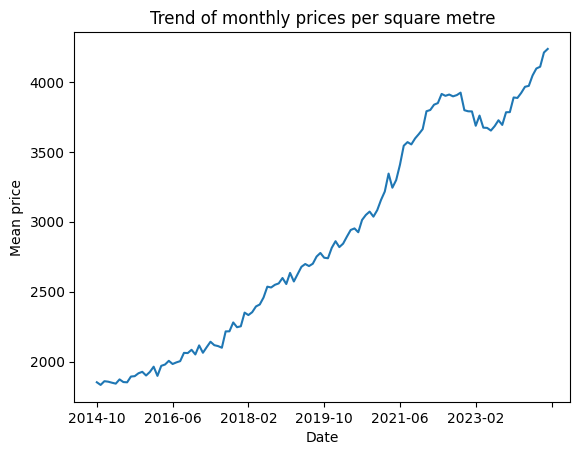

In [ ]:
transaction_df["DATUM"] = pd.to_datetime(transaction_df['DATUM'], dayfirst=True).dt.strftime('%Y-%m')
transaction_df["Price_per_sq_metre"] = np.exp(transaction_df["LOG_KOOPSOM"])/transaction_df["CALCOPP"]
mean_price = transaction_df.groupby("DATUM")["Price_per_sq_metre"].mean()
mean_price.plot(use_index=True, ylabel="Mean price", xlabel="Date", title="Trend of monthly prices per square metre")

In [ ]:
transaction_df.describe()

,TRANSID,WONINGTYPE,SOC,CALCOPP,KAVOPP,BOUWJAAR,BUURTCODE,LAT,LON,BESTEMMING,DUMMY_BERGING,DUMMY_GARAGE,DUMMY_MONUMENT,FOTOWIJZER_TYPE,LOG_KOOPSOM,price_per_sqm,MONTH,Price_per_sq_metre
count,1.089990e+05,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999.000000,108999,108999.000000
mean,6.254074e+06,1.331618,1166.538748,108.272140,138.721731,1969.256791,276.777457,51.908158,4.435299,1.001899,0.719419,0.130607,0.004716,8.451261,12.523725,2897.966237,2019-11-17 20:21:50.676244736,2897.966237
min,4.329352e+06,0.000000,1101.000000,17.000000,0.000000,1545.000000,0.000000,51.801753,4.054527,0.000000,0.000000,0.000000,0.000000,1.000000,10.373491,900.000000,2014-10-01 00:00:00,900.000000
25%,4.987456e+06,0.000000,1131.000000,80.000000,0.000000,1952.000000,189.000000,51.874245,4.354368,1.000000,0.000000,0.000000,0.000000,6.000000,12.180755,2061.403509,2017-07-04 00:00:00,2061.403509
50%,5.808585e+06,1.000000,1161.000000,104.000000,91.000000,1974.000000,236.000000,51.914207,4.470717,1.000000,1.000000,0.000000,0.000000,7.000000,12.524526,2739.837398,2019-12-03 00:00:00,2739.837398
75%,8.018244e+06,3.000000,1184.000000,128.000000,157.000000,1995.000000,369.000000,51.934236,4.528781,1.000000,1.000000,0.000000,0.000000,10.000000,12.860999,3541.666667,2022-03-15 00:00:00,3541.666667
max,8.864726e+06,4.000000,1888.000000,1150.000000,37430.000000,2024.000000,624.000000,52.058173,4.643221,2.000000,1.000000,1.000000,1.000000,51.000000,15.189226,13095.238095,2024-09-30 00:00:00,13095.238095
std,1.473208e+06,1.429253,66.031244,41.356986,559.580145,31.872989,145.789427,0.042853,0.127714,0.045192,0.449285,0.336971,0.068509,4.835099,0.522347,1100.675582,NaN,1100.675582


In [49]:
import geopandas as gpd

wijk_buurt_kaart_df = gpd.read_file("../../housing-data/WijkBuurtkaart_2023/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg")
wijk_buurt_kaart_df.columns

c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


Index(['buurtcode', 'buurtnaam', 'wijkcode', 'gemeentecode', 'gemeentenaam',
       'indelingswijziging_wijken_en_buurten', 'water',
       'meest_voorkomende_postcode', 'dekkingspercentage',
       'omgevingsadressendichtheid',
       ...
       'afstand_tot_open_nat_natuurlijk_terrein',
       'afstand_tot_semiopenbaar_groen_totaal', 'afstand_tot_sportterrein',
       'afstand_tot_volkstuin', 'afstand_tot_verblijfsrecreatief_terrein',
       'afstand_tot_recreatief_binnenwater', 'afstand_tot_begraafplaats',
       'jrstatcode', 'jaar', 'geometry'],
      dtype='object', length=224)

In [50]:
gemeentes_rotterdam = ['GM1930','GM0502', 'GM0622','GM0597',
 'GM0556',
 'GM0489',
 'GM0606',
 'GM1621',
 'GM1992',
 'GM0613',
 'GM0542',
 'GM0599']

In [51]:
gdf_2023= gpd.read_file("../../housing-data/cbsgebiedsindelingen2016-2025/cbsgebiedsindelingen2023.gpkg", layer="buurt_gegeneraliseerd")
gdf_2023

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
0,BU00340101,2023BU00340101,Centrum Haven Noord,GM0034,buurt,1,"MULTIPOLYGON (((143508.204 483344.282, 143707...."
1,BU00340102,2023BU00340102,Centrum Haven Zuid,GM0034,buurt,2,"MULTIPOLYGON (((143728.65 483029.012, 143730.8..."
2,BU00340201,2023BU00340201,Rozenwerf en Tuinderswerf,GM0034,buurt,3,"MULTIPOLYGON (((144118.02 483591.859, 144295.6..."
3,BU00340202,2023BU00340202,Achterwerf,GM0034,buurt,4,"MULTIPOLYGON (((144427.109 483263.953, 144384...."
4,BU00340203,2023BU00340203,Goedewerf en Wittewerf,GM0034,buurt,5,"MULTIPOLYGON (((144267.821 483312.403, 144090...."
...,...,...,...,...,...,...,...
14416,BU03850501,2023BU03850501,Warder,GM0385,buurt,14417,"MULTIPOLYGON (((130959.382 509613.307, 130850...."
14417,BU03850601,2023BU03850601,Middelie,GM0385,buurt,14418,"MULTIPOLYGON (((128874.917 507747.278, 130244...."
14418,BU03850701,2023BU03850701,Kwadijk,GM0385,buurt,14419,"MULTIPOLYGON (((127500.256 506394.557, 128625...."
14419,BU03850801,2023BU03850801,Schardam,GM0385,buurt,14420,"MULTIPOLYGON (((130104.529 513486.749, 130091...."


In [52]:
gef_rijnmond = gdf_2023[gdf_2023["gm_code"].isin(gemeentes_rotterdam)]
gef_rijnmond

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
3657,BU04890101,2023BU04890101,Centrum,GM0489,buurt,3658,"MULTIPOLYGON (((96663.776 430002.591, 96789.07..."
3658,BU04890102,2023BU04890102,Centrum Oost,GM0489,buurt,3659,"MULTIPOLYGON (((97129.146 429625.191, 97107.28..."
3659,BU04890103,2023BU04890103,Centrum West,GM0489,buurt,3660,"MULTIPOLYGON (((96381.123 430511.161, 96378.71..."
3660,BU04890204,2023BU04890204,Noord 1,GM0489,buurt,3661,"MULTIPOLYGON (((97237.35 430420.163, 96907.768..."
3661,BU04890205,2023BU04890205,Noord 2,GM0489,buurt,3662,"MULTIPOLYGON (((96943.148 430037.773, 96680.87..."
...,...,...,...,...,...,...,...
11055,BU06061005,2023BU06061005,Sveaborg en Sveadal,GM0606,buurt,11056,"MULTIPOLYGON (((86214.444 440408.06, 86202.202..."
11056,BU06061006,2023BU06061006,Sveaholm,GM0606,buurt,11057,"MULTIPOLYGON (((86202.202 440011.621, 86214.99..."
11057,BU06061007,2023BU06061007,Sveafors,GM0606,buurt,11058,"MULTIPOLYGON (((86357.781 439375.809, 86037.76..."
11058,BU06061101,2023BU06061101,Noordkethelpolder,GM0606,buurt,11059,"MULTIPOLYGON (((86040.048 441170.913, 85699.00..."


In [53]:
combined_df

,window_start,TRANSID,y_true,y_pred_baseline,y_pred_final,y_pred_lgbm,DATE,residual_baseline,residual_final,residual_lgbm,...,BOUWJAAR,BUURTCODE,LAT,LON,BESTEMMING,DUMMY_BERGING,DUMMY_GARAGE,DUMMY_MONUMENT,FOTOWIJZER_TYPE,LOG_KOOPSOM
0,2014-10,5781036,12.103480,11.973205,11.999034,11.944604,2019-11-01,-0.130275,-0.104446,-0.158876,...,1983,238,51.966098,4.577723,1.0,0,0,0,10,12.103481
1,2014-10,5781115,12.409014,12.175118,12.205646,12.285646,2019-11-01,-0.233896,-0.203368,-0.123368,...,1960,369,51.910246,4.312730,1.0,1,0,0,6,12.409013
2,2014-10,5781187,13.369224,13.002164,12.999840,13.219474,2019-11-01,-0.367060,-0.369384,-0.149750,...,1979,144,51.927757,4.618460,1.0,0,1,0,1,13.369223
3,2014-10,5781202,12.847926,12.350430,12.736402,12.875674,2019-11-01,-0.497495,-0.111524,0.027748,...,1992,233,51.927915,4.542278,1.0,1,0,0,6,12.847927
4,2014-10,5781203,11.982929,12.154861,12.142423,12.183546,2019-11-01,0.171932,0.159494,0.200617,...,1963,618,51.881156,4.179800,1.0,1,0,0,6,11.982929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54666,2019-07,8741507,12.748397,12.776637,12.709660,12.525717,2024-08-01,0.028240,-0.038737,-0.222680,...,1909,297,51.906168,4.407273,1.0,1,0,0,6,12.748397
54667,2019-07,8741513,12.415117,12.344392,12.427144,12.438578,2024-08-01,-0.070725,0.012027,0.023461,...,1985,231,51.892673,4.569312,1.0,1,0,0,10,12.415117
54668,2019-07,8741549,13.190022,13.074518,12.880836,12.844165,2024-08-01,-0.115504,-0.309186,-0.345857,...,1910,610,51.900321,4.165088,1.0,1,0,0,2,13.190022
54669,2019-07,8741579,12.971540,12.933887,12.975790,12.890431,2024-08-01,-0.037653,0.004250,-0.081109,...,1973,10,51.851396,4.539890,1.0,1,0,0,6,12.971540


In [54]:
rott_adj = pd.read_csv("../../housing-data/rotterdam_adj_2023.csv", index_col=0)
rott_adj

,BU04890101,BU04890102,BU04890103,BU04890204,BU04890205,BU04890206,BU04890207,BU04890308,BU04890409,BU04890410,...,BU06060904,BU06061001,BU06061002,BU06061003,BU06061004,BU06061005,BU06061006,BU06061007,BU06061101,BU06061102
BU04890101,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BU04890102,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BU04890103,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BU04890204,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BU04890205,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BU06061005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
BU06061006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
BU06061007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
BU06061101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [55]:
buuurt_codes = rott_adj.columns.tolist()
buuurt_codes

['BU04890101',
 'BU04890102',
 'BU04890103',
 'BU04890204',
 'BU04890205',
 'BU04890206',
 'BU04890207',
 'BU04890308',
 'BU04890409',
 'BU04890410',
 'BU04890511',
 'BU04890512',
 'BU04890513',
 'BU04890614',
 'BU04890715',
 'BU04890816',
 'BU04890817',
 'BU04890918',
 'BU04890919',
 'BU04890920',
 'BU04890921',
 'BU04890922',
 'BU04891023',
 'BU04891124',
 'BU04891225',
 'BU04891226',
 'BU04891227',
 'BU04891328',
 'BU04891429',
 'BU04891430',
 'BU04891431',
 'BU04891432',
 'BU04891533',
 'BU04891634',
 'BU04891735',
 'BU04891836',
 'BU04891937',
 'BU04892039',
 'BU04893050',
 'BU04893051',
 'BU04893052',
 'BU04893053',
 'BU04893054',
 'BU04893160',
 'BU04893161',
 'BU04893162',
 'BU04893163',
 'BU04893164',
 'BU04895070',
 'BU04895071',
 'BU04895072',
 'BU04895073',
 'BU04895074',
 'BU04895075',
 'BU04895076',
 'BU04895077',
 'BU04895078',
 'BU04895080',
 'BU04895081',
 'BU04895082',
 'BU04895083',
 'BU04895084',
 'BU05020110',
 'BU05020111',
 'BU05020112',
 'BU05020113',
 'BU050201

In [56]:
# replace buurtcodes in combined df with actual names in the buurt_codes list. The buurtcodes in the BUURTCODE column of the combined_df are the indexes of their corresponding buurt names in the buurt_codes list.
combined_df["BUURTCODE"] = combined_df["BUURTCODE"].apply(lambda x: buuurt_codes[int(x)] )

In [57]:
combined_df["BUURTCODE"] 

0        BU06220704
1        BU19301703
2        BU05420003
3        BU06220605
4        BU06061003
            ...    
54666    BU16213242
54667    BU06220603
54668    BU06060801
54669    BU04890511
54670    BU06220706
Name: BUURTCODE, Length: 54671, dtype: object

In [104]:
last12 = (
    combined_df["window_start"]          # or whatever your column is called
    .dropna()
    .sort_values()
    .unique()[-12:]                    # last 12 distinct windows
)

# ── 2.  Keep rows that belong to those windows ─────────────────────────────────
df_last12 = combined_df[combined_df["window_start"].isin(last12)]

# ── 3.  Compute Count, MSE, and MAPE per Buurtcode ─────────────────────────────
metrics_df = (
    df_last12
    .groupby("BUURTCODE")
    .apply(lambda g: pd.Series({
        "Count": len(g),
        "MSE":   np.median((g["y_true"] - g["y_pred_final"])**2),
        "MAPE":  np.median(np.abs((np.exp(g["y_true"]) - np.exp(g["y_pred_final"])) / np.exp(g["y_true"]))) * 100
    }))
    .reset_index()
)



merged = gef_rijnmond.merge(metrics_df, left_on='statcode', right_on='BUURTCODE', how='outer')
merged.fillna(0, inplace=True)
sorted_df = merged.sort_values(by="MAPE", ascending=False)
sorted_df.head(20)

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_27184\1436545843.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry,BUURTCODE,Count,MSE,MAPE
317,BU06060610,2023BU06060610,Wibautbuurt,GM0606,buurt,11039,"MULTIPOLYGON (((86155.371 437306.438, 86261.52...",BU06060610,2.0,0.344234,71.358014
265,BU05992459,2023BU05992459,Bedrijvenpark Noord-West,GM0599,buurt,10987,"MULTIPOLYGON (((88146.23 440111.76, 88183.91 4...",BU05992459,2.0,0.148272,41.785261
253,BU05991701,2023BU05991701,Strand en Duin,GM0599,buurt,10975,"MULTIPOLYGON (((68838.396 446317.597, 68730.71...",BU05991701,1.0,0.119917,41.381256
576,BU19920402,2023BU19920402,Morgen Stont,GM1992,buurt,10851,"MULTIPOLYGON (((70713.51 428626.17, 70854.34 4...",BU19920402,1.0,0.114057,40.175216
511,BU19301402,2023BU19301402,Kikkerveen,GM1930,buurt,8891,"MULTIPOLYGON (((82831.415 427850.701, 82505.86...",BU19301402,1.0,0.107014,38.698177
323,BU06060706,2023BU06060706,Bachplein,GM0606,buurt,11045,"MULTIPOLYGON (((85340.01 439361.465, 85367.605...",BU06060706,3.0,0.198230,35.932310
355,BU06130418,2023BU06130418,Rhoon-Zuidoost,GM0613,buurt,4610,"MULTIPOLYGON (((89559.355 430101.22, 89696.204...",BU06130418,1.0,0.087492,34.418919
264,BU05992308,2023BU05992308,Maasvlakte,GM0599,buurt,10986,"MULTIPOLYGON (((62856.608 445687.282, 65363.15...",BU05992308,7.0,0.133761,32.192036
419,BU16212111,2023BU16212111,Berkel Dorp,GM1621,buurt,7087,"MULTIPOLYGON (((92547.303 445608.51, 92830.905...",BU16212111,1.0,0.073703,31.190857
95,BU05020551,2023BU05020551,Beemster/Purmerhoek,GM0502,buurt,3780,"MULTIPOLYGON (((100860.851 439371.151, 100721....",BU05020551,1.0,0.071873,30.746611


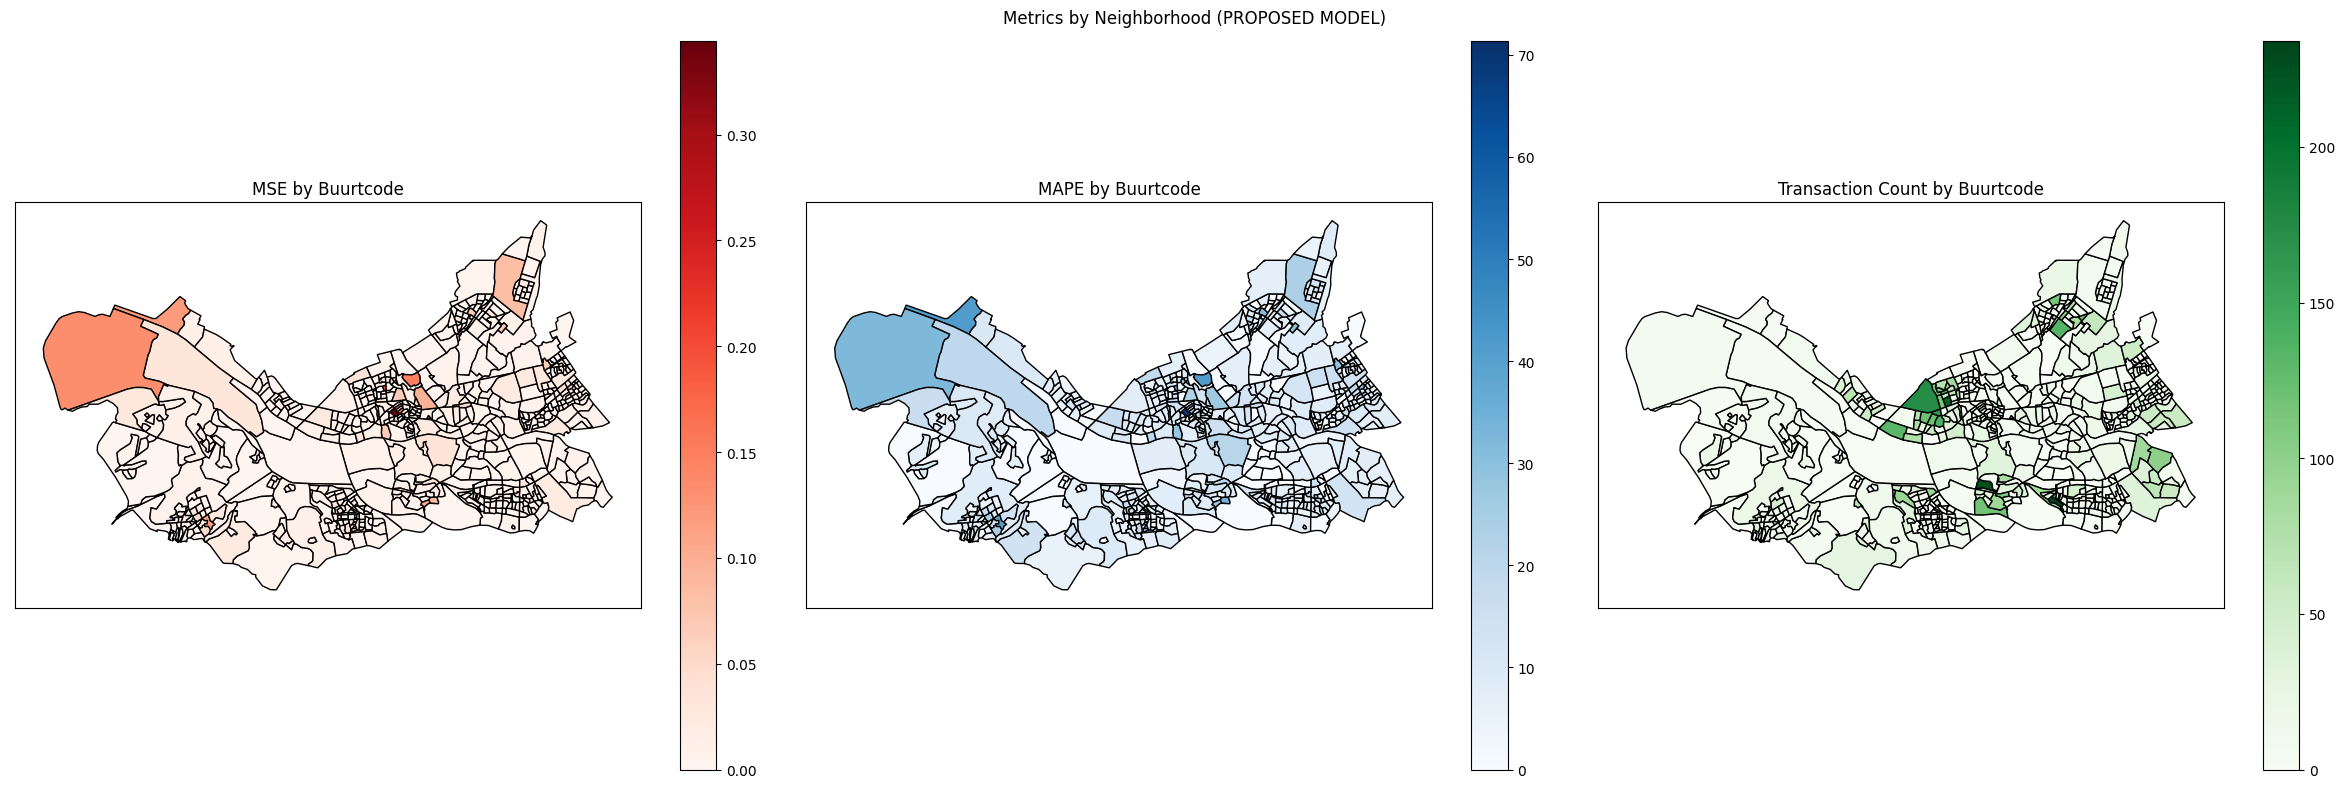

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

merged.plot(column="MSE", cmap="Reds", legend=True, ax=ax[0], edgecolor="black")
ax[0].set_title("MSE by Buurtcode")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
merged.plot(column="MAPE", cmap="Blues", legend=True, ax=ax[1], edgecolor="black")
ax[1].set_title("MAPE by Buurtcode")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

merged.plot(column="Count", cmap="Greens", legend=True, ax=ax[2], edgecolor="black")
ax[2].set_title("Transaction Count by Buurtcode")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

plt.suptitle("Metrics by Neighborhood (PROPOSED MODEL)")
plt.tight_layout()
plt.show()

In [102]:
last12 = (
    combined_df["window_start"]          # or whatever your column is called
    .dropna()
    .sort_values()
    .unique()[-12:]                    # last 12 distinct windows
)

# ── 2.  Keep rows that belong to those windows ─────────────────────────────────
df_last12 = combined_df[combined_df["window_start"].isin(last12)]

# ── 3.  Compute Count, MSE, and MAPE per Buurtcode ─────────────────────────────
metrics_df = (
    df_last12
    .groupby("BUURTCODE")
    .apply(lambda g: pd.Series({
        "Count": len(g),
        "MSE":   np.median((g["y_true"] - g["y_pred_lgbm"])**2),
        "MAPE":  np.median(np.abs((np.exp(g["y_true"]) - np.exp(g["y_pred_lgbm"])) / np.exp(g["y_true"]))) * 100
    }))
    .reset_index()
)



merged = gef_rijnmond.merge(metrics_df, left_on='statcode', right_on='BUURTCODE', how='outer')
merged.fillna(0, inplace=True)
sorted_df = merged.sort_values(by="MAPE", ascending=False)

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_27184\60727368.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [103]:
sorted_df.head(20)

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry,BUURTCODE,Count,MSE,MAPE
317,BU06060610,2023BU06060610,Wibautbuurt,GM0606,buurt,11039,"MULTIPOLYGON (((86155.371 437306.438, 86261.52...",BU06060610,2.0,0.355704,67.209893
355,BU06130418,2023BU06130418,Rhoon-Zuidoost,GM0613,buurt,4610,"MULTIPOLYGON (((89559.355 430101.22, 89696.204...",BU06130418,1.0,0.195034,55.523517
95,BU05020551,2023BU05020551,Beemster/Purmerhoek,GM0502,buurt,3780,"MULTIPOLYGON (((100860.851 439371.151, 100721....",BU05020551,1.0,0.156073,48.447428
576,BU19920402,2023BU19920402,Morgen Stont,GM1992,buurt,10851,"MULTIPOLYGON (((70713.51 428626.17, 70854.34 4...",BU19920402,1.0,0.115304,40.433476
176,BU05971100,2023BU05971100,Verenambacht,GM0597,buurt,4527,"MULTIPOLYGON (((98201.164 430044.442, 98037.65...",BU05971100,1.0,0.252399,39.491941
256,BU05991853,2023BU05991853,Spaanse Polder,GM0599,buurt,10978,"MULTIPOLYGON (((88598.344 438845.863, 89321 43...",BU05991853,1.0,0.217843,37.295447
61,BU04895084,2023BU04895084,BT Vaanpark 4,GM0489,buurt,3719,"MULTIPOLYGON (((94985.52 430533.131, 94991.727...",BU04895084,1.0,0.161901,33.126639
86,BU05020441,2023BU05020441,De Baronie,GM0502,buurt,3771,"MULTIPOLYGON (((101035.256 438648.335, 100698....",BU05020441,1.0,0.081609,33.065656
284,BU06060201,2023BU06060201,Vijfsluizen,GM0606,buurt,11006,"MULTIPOLYGON (((85390.408 436047.751, 85494.75...",BU06060201,6.0,0.081893,31.703163
323,BU06060706,2023BU06060706,Bachplein,GM0606,buurt,11045,"MULTIPOLYGON (((85340.01 439361.465, 85367.605...",BU06060706,3.0,0.093635,26.361170


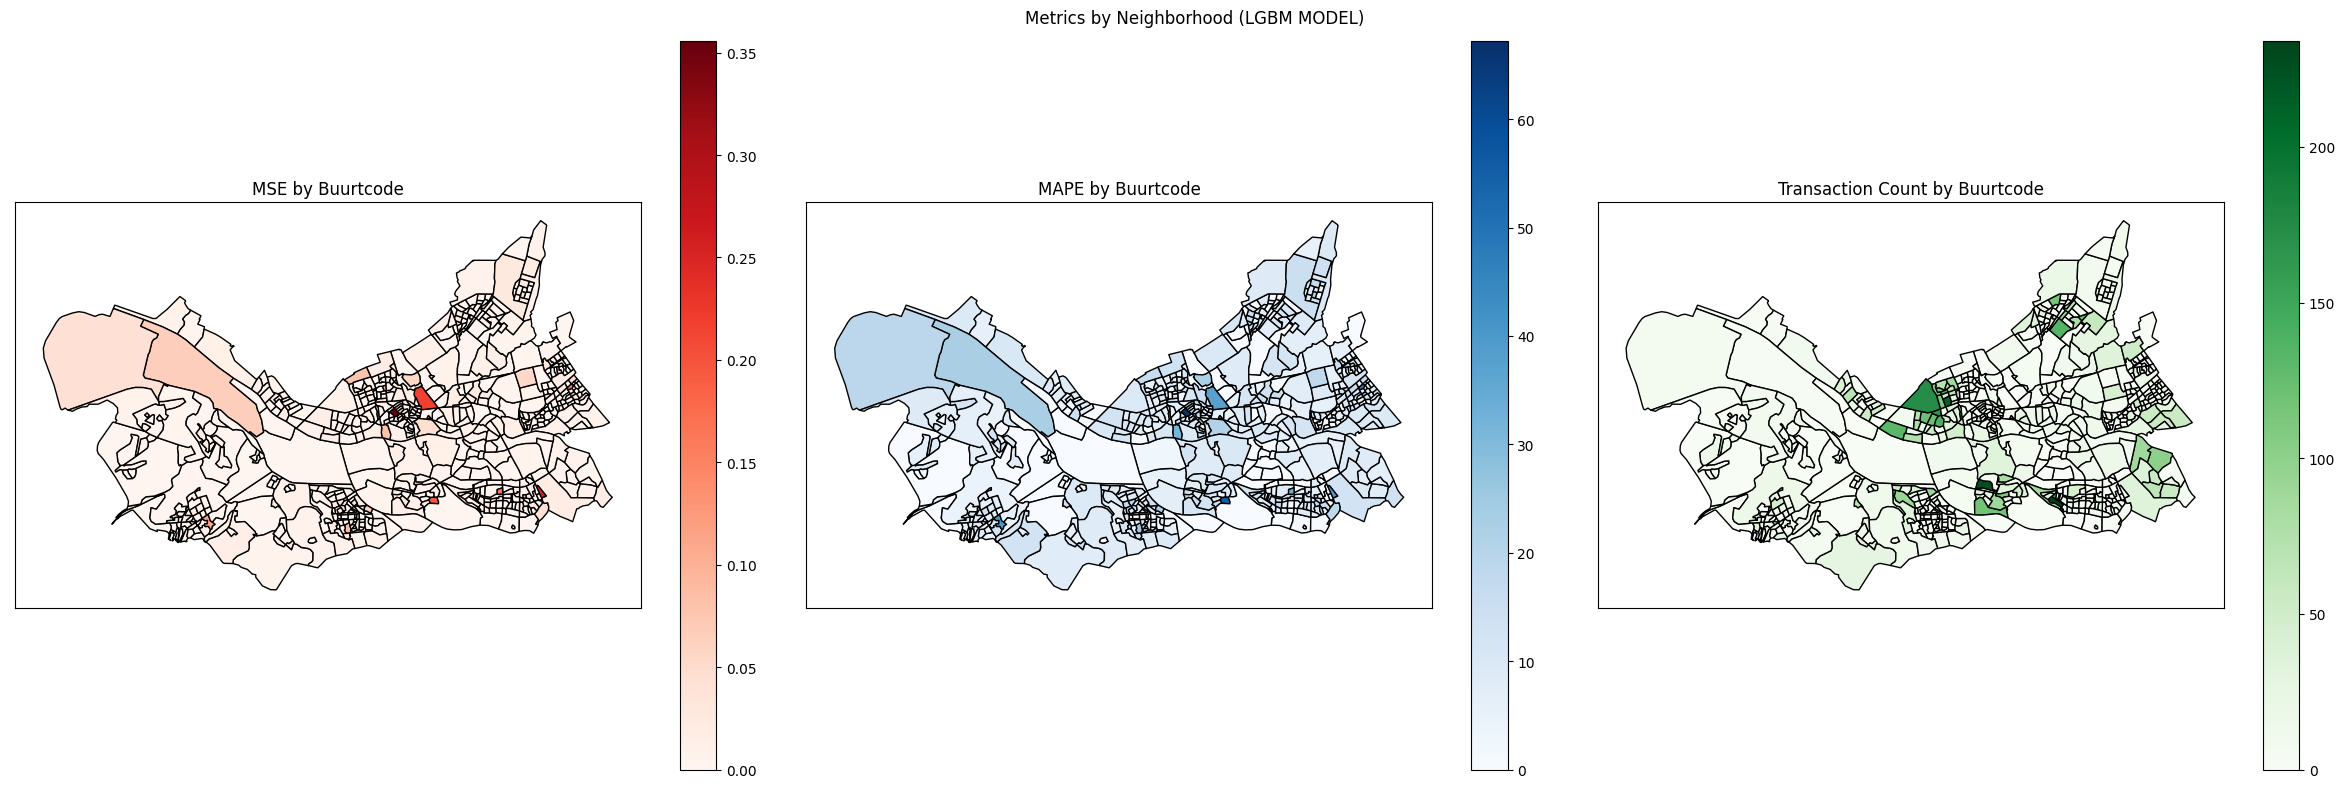

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

merged.plot(column="MSE", cmap="Reds", legend=True, ax=ax[0], edgecolor="black")
ax[0].set_title("MSE by Buurtcode")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
merged.plot(column="MAPE", cmap="Blues", legend=True, ax=ax[1], edgecolor="black")
ax[1].set_title("MAPE by Buurtcode")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

merged.plot(column="Count", cmap="Greens", legend=True, ax=ax[2], edgecolor="black")
ax[2].set_title("Transaction Count by Buurtcode")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

plt.suptitle("Metrics by Neighborhood (LGBM MODEL)")
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

In [4]:
trans_df = pd.read_csv("../../housing-data/transaction_data.csv")
trans_df

,TRANSID,DATUM,WONINGTYPE,SOC,CALCOPP,KAVOPP,BOUWJAAR,BUURTCODE,LAT,LON,BESTEMMING,DUMMY_BERGING,DUMMY_GARAGE,DUMMY_MONUMENT,FOTOWIJZER_TYPE,LOG_KOOPSOM
0,8324024,2023-03-13,3.0,1131,124,119,1976,13959,51.850627,4.893862,1.0,1,0,0,6,12.842649
1,4695633,2016-06-01,3.0,1131,145,208,2000,4785,52.492774,4.660815,1.0,1,0,0,6,12.456831
2,6267016,2020-11-16,3.0,1131,140,130,2014,2955,51.875469,5.868624,1.0,1,0,0,6,12.892950
3,6428993,2021-02-01,3.0,1136,261,162,1912,6448,52.091945,4.272226,1.0,1,0,0,6,13.910821
4,5382171,2018-12-04,0.0,1181,50,0,1974,7828,52.213655,4.862490,1.0,1,0,0,9,12.100712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606347,4527050,2015-09-02,3.0,1131,125,155,1975,3787,52.167385,5.285358,1.0,1,0,0,6,12.185870
1606348,8518792,2023-11-27,3.0,1138,123,98,1970,2583,52.046115,5.638586,1.0,0,1,0,6,12.791181
1606349,6068581,2020-06-16,0.0,1184,93,0,2001,3515,52.199698,5.369747,1.0,1,0,0,10,12.413087
1606350,4943077,2017-05-05,4.0,1111,165,367,1935,13973,51.940161,4.853196,1.0,1,0,0,1,12.765688


In [ ]:
# trans_df.to_parquet("../../housing-data/transaction_data_parq.parquet", index=False)